In [19]:
from sotip import *
import numpy as np
import scanpy as sc
import os
import squidpy as sq

# load all and concat

In [3]:
MIBI_dict = {
    'M':[33,31,18,21,7,8,23,27,2,38,14,20,11,29,39,1,17,12,13],
    'C':[34,36,6,40,5,41,10,3,9,32,4,28,37,16,35]
}

In [4]:
a_list = []
for tp in MIBI_dict.keys():
    for patient in MIBI_dict[tp]:
        cur_a = sc.read_h5ad(f'{data_root}/p{patient}.h5ad')
        cur_a.obs['TNBC'] = tp
        cur_a.obs['patient'] = patient
        a_list.append(cur_a)

In [5]:
adata = a_list[0].concatenate(a_list[1:])

In [6]:

data_name = 'p4'
data_root = 'path/to/h5ad'
adata_0 = sc.read_h5ad(f'{data_root}/{data_name}.h5ad')


In [7]:
adata.obs['all_group_name']= adata.obs['all_group_name'].cat.set_categories(adata_0.obs['all_group_name'].cat.categories)



In [56]:
def ME_contain_cls_count(interest_cls,patient_no,count_threshold=1):
    # interest_cls = ['Macrophages','Keratin+ tumor','CD8 T']
    
    cls_order = list(adata.obs['all_group_name'].cat.categories)
    interest_cls_idx = [cls_order.index(c) for c in interest_cls]
    adata_patient = adata[adata.obs['patient']==patient_no]
    ME_int_cls = np.array(adata_patient.obsm['ME'][:,interest_cls_idx])
    ME_count = np.sum(np.prod(ME_int_cls>=count_threshold,axis=1))
    
    
    unique,count = (np.unique(adata_patient.obs['all_group_name'],return_counts=1))
    unique_dict = dict(zip(unique,count))
    interest_cls_count_dict = {k:unique_dict[k] for k in interest_cls}
    return ME_count,interest_cls_count_dict,adata_patient.shape[0]

In [62]:
pd_dict = {
    'patient':[],
    'TNBC':[],
    'ME_int':[],
    'ME_total':[],
}

interest_cls = ['Macrophages','Keratin+ tumor','CD8 T']
count_threshold = 2

for int_cls in interest_cls:
    pd_dict[int_cls] = []
for p in np.unique(adata.obs['patient']):
    cur_a = adata[adata.obs['patient']==p]
    cur_TNBC = cur_a.obs['TNBC'][0]
    ME_count,interest_cls_count_dict,ME_total = ME_contain_cls_count(interest_cls,p,count_threshold)
    
    pd_dict['patient'].append(p)
    pd_dict['TNBC'].append(cur_TNBC)
    pd_dict['ME_int'].append(ME_count)
    pd_dict['ME_total'].append(ME_total)
    for key in interest_cls_count_dict.keys():
        pd_dict[key].append(interest_cls_count_dict[key])

In [63]:
pd_df = pd.DataFrame(pd_dict)

In [64]:
pd_df

patient TNBC  ME_int  ME_total  Macrophages  Keratin+ tumor  CD8 T
0         1    M      39      5167          281            2488    173
1         2    M     273      3028          511            1834    245
2         3    C      47      6315          726            2249    496
3         4    C       6      6643          880            1680    304
4         5    C      94      5406         1064            2125    531
5         6    C      64      5998          710            3345    206
6         7    M       0      3410          245            2551      4
7         8    M       7      3136          269            1479     50
8         9    C     117      6139         1236            2642    391
9        10    C     285      4580         1304            1500    410
10       11    M     130      5112          574            3193    302
11       12    M     579      6995         1413            3428    701
12       13    M     528      7665         1088            2244   2089
13       14    M     105      6270          345            5137    410
14       16    C      39      8212          494            1673   2433
15       17    M     151      7071          578            3693    584
16       18    M      13      5539          312            5021     51
17       20    M      42      5103          193            3405    475
18       21    M       0      5423          211            4727      8
19       23    M      17      4490          467            3492     61
20       27    M      12      4332          438            3093     33
21       28    C       5      6061          324            1270    192
22       29    M     163      4819          428            2724    784
23       31    M      17      3415          272            2895      6
24       32    C     709      5158         1410            1555   1273
25       33    M      13      2046          152            1232     38
26       34    C      61      2856          394            1187    178
27       35    C       0      7716          164             547    770
28       36    C      44      2939          409             413    370
29       37    C     102      6280          945            1127    979
30       38    M      38      4330          686            3198     42
31       39    M     191      4030          893            1541    553
32       40    C      10      4285          113             950    255
33       41    C      15      4532          507            1047    284

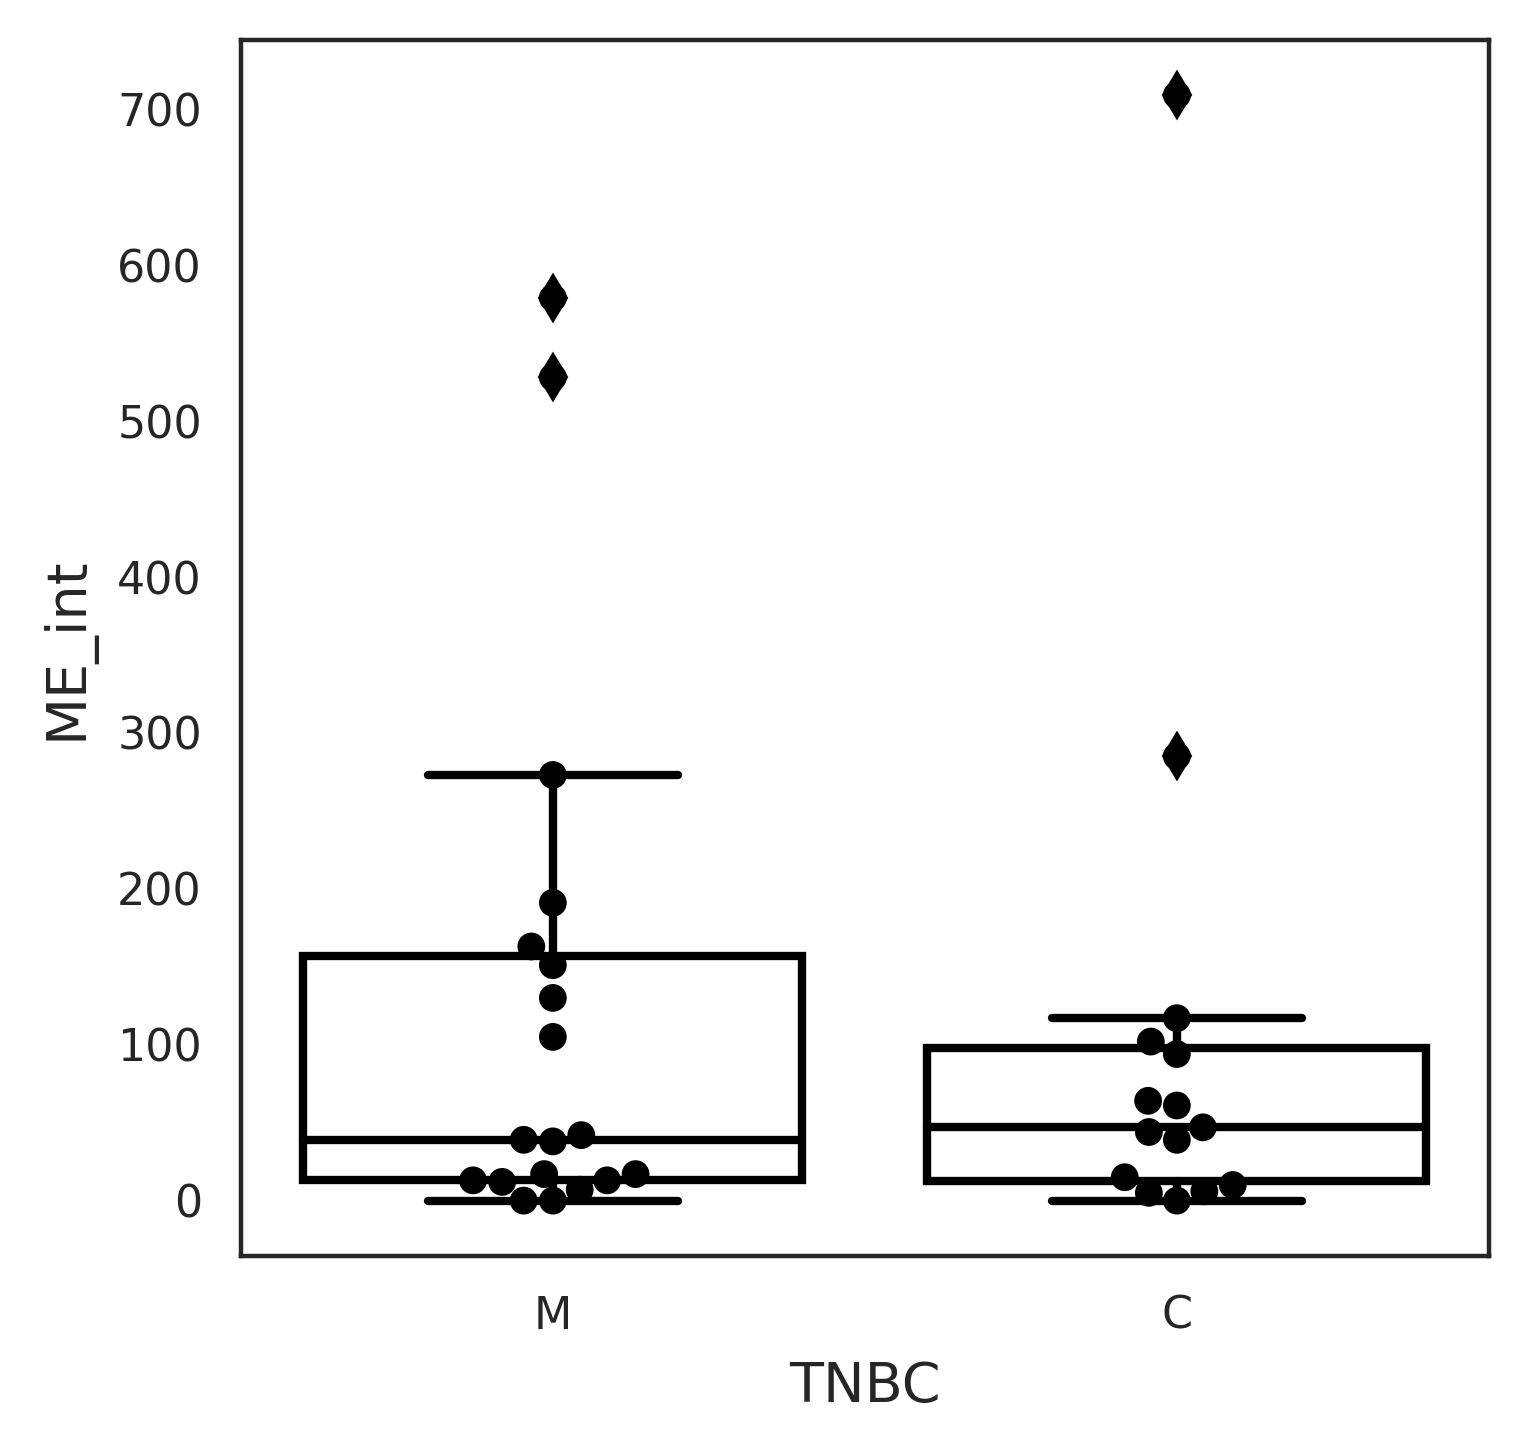

In [65]:
# sns.boxplot(data=pd_df,x='method',y='ari',)
order = ['M','C']
ax = sns.boxplot(x="TNBC", y="ME_int", data=pd_df,color='k',order=order)
ax = sns.swarmplot(x="TNBC", y="ME_int", data=pd_df,color='k',order=order)
# iterate over boxes
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')
# plt.ylim(0.5, 1)

In [66]:
pd_df[pd_df.TNBC=='M']['ME_int']

0      39
1     273
6       0
7       7
10    130
11    579
12    528
13    105
15    151
16     13
17     42
18      0
19     17
20     12
22    163
23     17
25     13
30     38
31    191
Name: ME_int, dtype: int64

In [69]:
import pingouin

In [71]:
pingouin.mwu(pd_df[pd_df.TNBC=='M']['ME_int'],pd_df[pd_df.TNBC=='C']['ME_int'],alternative='greater')

U-val alternative     p-val       RBC      CLES
MWU  147.5     greater  0.437952 -0.035088  0.517544

# random perm

In [8]:
def ME_contain_cls_count(interest_cls,adata_p,count_threshold=1):
    # interest_cls = ['Macrophages','Keratin+ tumor','CD8 T']
    cls_key = 'all_group_name'
    cls_order = adata.obs[cls_key].cat.categories
    
    adata_p.obs[cls_key] = adata_p.obs[cls_key].cat.set_categories(cls_order)
    
    knn = 10
    spatial_var='spatial'
    ME_var_names_np_unique = np.array(adata_p.obs[cls_key].cat.categories)

    MED(adata_p,use_cls=cls_key,nn=knn,copy=False,spatial_var=spatial_var,ME_var_names_np_unique=ME_var_names_np_unique)
  

    
    
    interest_cls_idx = [list(cls_order).index(c) for c in interest_cls]
    
    
    
    ME_int_cls = np.array(adata_p.obsm['ME'][:,interest_cls_idx])
    ME_count = np.sum(np.prod(ME_int_cls>=count_threshold,axis=1))
    

    return ME_count

In [9]:
cls_key = 'all_group_name'
interest_cls = ['Macrophages','Keratin+ tumor','CD8 T']
count_threshold = 2
adata_p = adata[adata.obs['patient']==4]
ME_contain_cls_count(interest_cls,adata_p,count_threshold,)

Trying to set attribute `.obs` of view, copying.


knn search time cost 0.015697717666625977 s
0 MEs,time cost 2.1457672119140625e-06 s, 6643 MEs, 1.4254331588745117e-05s left
1000 MEs,time cost 0.14769554138183594 s, 5643 MEs, 0.8334459400177002s left
2000 MEs,time cost 0.15207338333129883 s, 4643 MEs, 0.7060767188072204s left
3000 MEs,time cost 0.14896440505981445 s, 3643 MEs, 0.5426773276329041s left
4000 MEs,time cost 0.15644621849060059 s, 2643 MEs, 0.41348735547065735s left
5000 MEs,time cost 0.15347528457641602 s, 1643 MEs, 0.2521598925590515s left
6000 MEs,time cost 0.1523418426513672 s, 643 MEs, 0.0979558048248291s left


6

In [77]:
np.random.permutation(np.array(adata_p.obs[cls_key]))

array(['Keratin+ tumor', 'Other immune', 'Macrophages', ...,
       'Macrophages', 'DC/Mono', 'Keratin+ tumor'], dtype=object)

In [13]:
# adata_p,obs,cat


def adata_perm(adata,obs,cat):
    adata_perm = adata_p.copy()
    label_array = np.array(adata_perm.obs[obs])
    label_array_new = np.random.permutation(label_array)
    adata_perm.obs[obs] = label_array_new
    adata_perm.obs[obs] = adata_perm.obs[obs].astype('category')
    adata_perm.obs[obs] = adata_perm.obs[obs].cat.set_categories(cat)
    return adata_perm



In [12]:
cat = adata.obs[cls_key].cat.categories
adata_p_perm = adata_perm(adata_p,cls_key,cat)

### run rdpm one patient

In [93]:
p = 12
cls_key = 'all_group_name'
interest_cls = ['Macrophages','Keratin+ tumor','CD8 T']
count_threshold = 1

adata_p = adata[adata.obs['patient']==p]
ME_count = ME_contain_cls_count(interest_cls,adata_p,count_threshold)
ME_count_perm_list = []
cat = adata.obs[cls_key].cat.categories
for i in range(100):
    adata_p_perm = adata_perm(adata_p,cls_key,cat)
    ME_count_perm = ME_contain_cls_count(interest_cls,adata_p_perm,count_threshold)
    ME_count_perm_list.append(ME_count_perm)
    

Trying to set attribute `.obs` of view, copying.


knn search time cost 0.01741337776184082 s
0 MEs,time cost 2.6226043701171875e-06 s, 6995 MEs, 1.8345117568969725e-05s left
1000 MEs,time cost 0.14866185188293457 s, 5995 MEs, 0.8912278020381927s left
2000 MEs,time cost 0.16107821464538574 s, 4995 MEs, 0.8045856821537017s left
3000 MEs,time cost 0.14892840385437012 s, 3995 MEs, 0.5949689733982086s left
4000 MEs,time cost 0.15718674659729004 s, 2995 MEs, 0.47077430605888365s left
5000 MEs,time cost 0.1501762866973877 s, 1995 MEs, 0.29960169196128844s left
6000 MEs,time cost 0.15839886665344238 s, 995 MEs, 0.15760687232017517s left
knn search time cost 0.016571760177612305 s
0 MEs,time cost 2.6226043701171875e-06 s, 6995 MEs, 1.8345117568969725e-05s left
1000 MEs,time cost 0.1624917984008789 s, 5995 MEs, 0.974138331413269s left
2000 MEs,time cost 0.15057086944580078 s, 4995 MEs, 0.7521014928817749s left
3000 MEs,time cost 0.1509571075439453 s, 3995 MEs, 0.6030736446380616s left
4000 MEs,time cost 0.15417861938476562 s, 2995 MEs, 0.461764

### run rdpm all patient for M, K ,CD

In [100]:
pd_dict

{'patient': [1, 2, 3, 4, 5, 6, 7],
 'TNBC': ['M', 'M', 'C', 'C', 'C', 'C', 'M'],
 'ME_int': [450, 1219, 553, 127, 458, 417, 25],
 'ME_int_bg_mean': [595.71, 1422.62, 2349.33, 1675.45, 3009.83, 1207.7, 19.12],
 'ME_int_bg_var': [1821.1659,
  1775.8156000000004,
  2610.5011,
  3212.8075,
  3381.7810999999997,
  1899.25,
  47.1456],
 'ME_int_bg_std': [42.67512038647343,
  42.14042714543839,
  51.093063129939665,
  56.68163282757475,
  58.153083323242626,
  43.58038549622984,
  6.866265360441584]}

In [ ]:
pd_dict = {
    'patient':[],
    'TNBC':[],
    'ME_int':[],
    'ME_int_bg_mean':[],
    'ME_int_bg_var':[],
    'ME_int_bg_std':[],
    
}

cls_key = 'all_group_name'
interest_cls = ['Macrophages','Keratin+ tumor','CD8 T']
count_threshold = 1
perm_times = 500

for p in np.unique(adata.obs['patient']):
    time_start = time.time()
    adata_p = adata[adata.obs['patient']==p]
    cur_TNBC = adata_p.obs['TNBC'][0]
    ME_count = ME_contain_cls_count(interest_cls,adata_p,count_threshold)
    ME_count_perm_list = []
    cat = adata.obs[cls_key].cat.categories
    for i in range(perm_times):
        adata_p_perm = adata_perm(adata_p,cls_key,cat)
        ME_count_perm = ME_contain_cls_count(interest_cls,adata_p_perm,count_threshold)
        ME_count_perm_list.append(ME_count_perm)
    ME_int_bg_mean = np.mean(ME_count_perm_list)
    ME_int_bg_var = np.var(ME_count_perm_list)
    ME_int_bg_std = np.std(ME_count_perm_list)
    
    pd_dict['patient'].append(p)
    pd_dict['TNBC'].append(cur_TNBC)
    pd_dict['ME_int'].append(ME_count)
    pd_dict['ME_int_bg_mean'].append(ME_int_bg_mean)
    pd_dict['ME_int_bg_var'].append(ME_int_bg_var)
    pd_dict['ME_int_bg_std'].append(ME_int_bg_std)
    time_end = time.time()
    print(f'p:{p},time_cost:{time_end-time_start}')

    
    
    

Trying to set attribute `.obs` of view, copying.


knn search time cost 0.011371612548828125 s
0 MEs,time cost 2.6226043701171875e-06 s, 5167 MEs, 1.3550996780395509e-05s left
1000 MEs,time cost 0.156477689743042 s, 4167 MEs, 0.652042533159256s left
2000 MEs,time cost 0.151200532913208 s, 3167 MEs, 0.47885208773612975s left
3000 MEs,time cost 0.14824247360229492 s, 2167 MEs, 0.3212414402961731s left
4000 MEs,time cost 0.1499803066253662 s, 1167 MEs, 0.17502701783180236s left
5000 MEs,time cost 0.15085387229919434 s, 167 MEs, 0.025192596673965454s left
knn search time cost 0.011318683624267578 s
0 MEs,time cost 2.6226043701171875e-06 s, 5167 MEs, 1.3550996780395509e-05s left
1000 MEs,time cost 0.15333819389343262 s, 4167 MEs, 0.6389602539539337s left
2000 MEs,time cost 0.15198349952697754 s, 3167 MEs, 0.4813317430019379s left
3000 MEs,time cost 0.1678309440612793 s, 2167 MEs, 0.3636896557807922s left
4000 MEs,time cost 0.14947938919067383 s, 1167 MEs, 0.17444244718551635s left
5000 MEs,time cost 0.1590864658355713 s, 167 MEs, 0.02656743

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.15061092376708984 s, 1167 MEs, 0.17576294803619386s left
5000 MEs,time cost 0.14962100982666016 s, 167 MEs, 0.024986708641052246s left
p:1,time_cost:417.55345821380615
knn search time cost 0.006715297698974609 s
0 MEs,time cost 3.0994415283203125e-06 s, 3028 MEs, 9.385108947753906e-06s left
1000 MEs,time cost 0.1559910774230957 s, 2028 MEs, 0.3163499050140381s left
2000 MEs,time cost 0.14698147773742676 s, 1028 MEs, 0.1510969591140747s left
3000 MEs,time cost 0.1457986831665039 s, 28 MEs, 0.004082363128662109s left
knn search time cost 0.0068073272705078125 s
0 MEs,time cost 3.0994415283203125e-06 s, 3028 MEs, 9.385108947753906e-06s left
1000 MEs,time cost 0.14675545692443848 s, 2028 MEs, 0.29762006664276125s left
2000 MEs,time cost 0.1477982997894287 s, 1028 MEs, 0.15193665218353272s left
3000 MEs,time cost 0.14708900451660156 s, 28 MEs, 0.0041184921264648434s left
knn search time cost 0.006817817687988281 s
0 MEs,time cost 2.6226043701171875e-06 s, 3028 MEs, 7.94

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.15187406539916992 s, 28 MEs, 0.004252473831176758s left
p:2,time_cost:244.52301597595215
knn search time cost 0.01436924934387207 s
0 MEs,time cost 3.0994415283203125e-06 s, 6315 MEs, 1.9572973251342773e-05s left
1000 MEs,time cost 0.14969372749328613 s, 5315 MEs, 0.7956221616268158s left
2000 MEs,time cost 0.15391254425048828 s, 4315 MEs, 0.664132628440857s left
3000 MEs,time cost 0.14560866355895996 s, 3315 MEs, 0.48269271969795224s left
4000 MEs,time cost 0.14879918098449707 s, 2315 MEs, 0.3444701039791107s left
5000 MEs,time cost 0.1470644474029541 s, 1315 MEs, 0.19338974833488465s left
6000 MEs,time cost 0.15264248847961426 s, 315 MEs, 0.04808238387107849s left
knn search time cost 0.014438152313232422 s
0 MEs,time cost 3.337860107421875e-06 s, 6315 MEs, 2.107858657836914e-05s left
1000 MEs,time cost 0.1562793254852295 s, 5315 MEs, 0.8306246149539948s left
2000 MEs,time cost 0.15439248085021973 s, 4315 MEs, 0.6662035548686981s left
3000 MEs,time cost 0.1622323

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.16009926795959473 s, 315 MEs, 0.05043126940727234s left
p:3,time_cost:549.216864824295
knn search time cost 0.01546478271484375 s
0 MEs,time cost 2.6226043701171875e-06 s, 6643 MEs, 1.7421960830688475e-05s left
1000 MEs,time cost 0.14263701438903809 s, 5643 MEs, 0.804900672197342s left
2000 MEs,time cost 0.14957904815673828 s, 4643 MEs, 0.6944955205917358s left
3000 MEs,time cost 0.1502854824066162 s, 3643 MEs, 0.5474900124073029s left
4000 MEs,time cost 0.1506037712097168 s, 2643 MEs, 0.3980457673072815s left
5000 MEs,time cost 0.16101813316345215 s, 1643 MEs, 0.2645527927875519s left
6000 MEs,time cost 0.14974474906921387 s, 643 MEs, 0.09628587365150451s left
knn search time cost 0.015581130981445312 s
0 MEs,time cost 2.6226043701171875e-06 s, 6643 MEs, 1.7421960830688475e-05s left
1000 MEs,time cost 0.15958619117736816 s, 5643 MEs, 0.9005448768138885s left
2000 MEs,time cost 0.15963125228881836 s, 4643 MEs, 0.7411679043769837s left
3000 MEs,time cost 0.158928871

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.16161561012268066 s, 643 MEs, 0.10391883730888367s left
p:4,time_cost:591.3808386325836
knn search time cost 0.012020349502563477 s
0 MEs,time cost 2.86102294921875e-06 s, 5406 MEs, 1.5466690063476562e-05s left
1000 MEs,time cost 0.15682125091552734 s, 4406 MEs, 0.6909544315338135s left
2000 MEs,time cost 0.16198301315307617 s, 3406 MEs, 0.5517141427993775s left
3000 MEs,time cost 0.14861369132995605 s, 2406 MEs, 0.35756454133987425s left
4000 MEs,time cost 0.14593791961669922 s, 1406 MEs, 0.2051887149810791s left
5000 MEs,time cost 0.14398956298828125 s, 406 MEs, 0.05845976257324219s left
knn search time cost 0.012026548385620117 s
0 MEs,time cost 2.6226043701171875e-06 s, 5406 MEs, 1.4177799224853516e-05s left
1000 MEs,time cost 0.15565752983093262 s, 4406 MEs, 0.6858270764350891s left
2000 MEs,time cost 0.15440130233764648 s, 3406 MEs, 0.5258908357620239s left
3000 MEs,time cost 0.15701508522033691 s, 2406 MEs, 0.3777782950401306s left
4000 MEs,time cost 0.16379

Trying to set attribute `.obs` of view, copying.


p:5,time_cost:435.2518217563629
knn search time cost 0.013508081436157227 s
0 MEs,time cost 1.9073486328125e-06 s, 5998 MEs, 1.1440277099609375e-05s left
1000 MEs,time cost 0.1694355010986328 s, 4998 MEs, 0.8468386344909667s left
2000 MEs,time cost 0.1715993881225586 s, 3998 MEs, 0.6860543537139893s left
3000 MEs,time cost 0.17120146751403809 s, 2998 MEs, 0.5132619996070862s left
4000 MEs,time cost 0.1436452865600586 s, 1998 MEs, 0.2870032825469971s left
5000 MEs,time cost 0.15623974800109863 s, 998 MEs, 0.15592726850509644s left
knn search time cost 0.013549089431762695 s
0 MEs,time cost 1.9073486328125e-06 s, 5998 MEs, 1.1440277099609375e-05s left
1000 MEs,time cost 0.15074920654296875 s, 4998 MEs, 0.7534445343017578s left
2000 MEs,time cost 0.15843868255615234 s, 3998 MEs, 0.633437852859497s left
3000 MEs,time cost 0.15076637268066406 s, 2998 MEs, 0.45199758529663087s left
4000 MEs,time cost 0.17444205284118652 s, 1998 MEs, 0.3485352215766907s left
5000 MEs,time cost 0.1748766899108

Trying to set attribute `.obs` of view, copying.


p:6,time_cost:503.95314955711365
knn search time cost 0.008229255676269531 s
0 MEs,time cost 1.6689300537109375e-06 s, 3410 MEs, 5.691051483154297e-06s left
1000 MEs,time cost 0.14226984977722168 s, 2410 MEs, 0.34287033796310423s left
2000 MEs,time cost 0.1628422737121582 s, 1410 MEs, 0.22960760593414306s left
3000 MEs,time cost 0.14075064659118652 s, 410 MEs, 0.057707765102386475s left
knn search time cost 0.007837533950805664 s
0 MEs,time cost 1.1444091796875e-05 s, 3410 MEs, 3.902435302734375e-05s left
1000 MEs,time cost 0.16891145706176758 s, 2410 MEs, 0.4070766115188599s left
2000 MEs,time cost 0.16762208938598633 s, 1410 MEs, 0.23634714603424073s left
3000 MEs,time cost 0.14482712745666504 s, 410 MEs, 0.059379122257232665s left
knn search time cost 0.007831811904907227 s
0 MEs,time cost 1.9073486328125e-06 s, 3410 MEs, 6.504058837890625e-06s left
1000 MEs,time cost 0.14548063278198242 s, 2410 MEs, 0.3506083250045776s left
2000 MEs,time cost 0.15702271461486816 s, 1410 MEs, 0.2214

Trying to set attribute `.obs` of view, copying.


2000 MEs,time cost 0.1674489974975586 s, 1410 MEs, 0.23610308647155762s left
3000 MEs,time cost 0.16168498992919922 s, 410 MEs, 0.06629084587097168s left
p:7,time_cost:280.66344165802
knn search time cost 0.0070285797119140625 s
0 MEs,time cost 2.1457672119140625e-06 s, 3136 MEs, 6.7291259765625e-06s left
1000 MEs,time cost 0.17486882209777832 s, 2136 MEs, 0.3735198040008545s left
2000 MEs,time cost 0.15467238426208496 s, 1136 MEs, 0.1757078285217285s left
3000 MEs,time cost 0.16870927810668945 s, 136 MEs, 0.022944461822509764s left
knn search time cost 0.007036447525024414 s
0 MEs,time cost 1.9073486328125e-06 s, 3136 MEs, 5.9814453125e-06s left
1000 MEs,time cost 0.16011905670166016 s, 2136 MEs, 0.3420143051147461s left
2000 MEs,time cost 0.17519927024841309 s, 1136 MEs, 0.19902637100219728s left
3000 MEs,time cost 0.17404413223266602 s, 136 MEs, 0.023670001983642577s left
knn search time cost 0.0071904659271240234 s
0 MEs,time cost 1.9073486328125e-06 s, 3136 MEs, 5.9814453125e-06s 

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.16695713996887207 s, 136 MEs, 0.022706171035766602s left
p:8,time_cost:267.3242688179016
knn search time cost 0.013853311538696289 s
0 MEs,time cost 1.6689300537109375e-06 s, 6139 MEs, 1.0245561599731445e-05s left
1000 MEs,time cost 0.1585063934326172 s, 5139 MEs, 0.8145643558502197s left
2000 MEs,time cost 0.17276453971862793 s, 4139 MEs, 0.715072429895401s left
3000 MEs,time cost 0.16854310035705566 s, 3139 MEs, 0.5290567920207977s left
4000 MEs,time cost 0.15068387985229492 s, 2139 MEs, 0.32231281900405884s left
5000 MEs,time cost 0.17259001731872559 s, 1139 MEs, 0.19658002972602845s left
6000 MEs,time cost 0.16611504554748535 s, 139 MEs, 0.023089991331100464s left
knn search time cost 0.013939380645751953 s
0 MEs,time cost 2.1457672119140625e-06 s, 6139 MEs, 1.3172864913940429e-05s left
1000 MEs,time cost 0.17858147621154785 s, 5139 MEs, 0.9177302062511444s left
2000 MEs,time cost 0.16511082649230957 s, 4139 MEs, 0.6833937108516693s left
3000 MEs,time cost 0.16

Trying to set attribute `.obs` of view, copying.


p:9,time_cost:532.9377727508545
knn search time cost 0.009873390197753906 s
0 MEs,time cost 2.384185791015625e-06 s, 4580 MEs, 1.0919570922851562e-05s left
1000 MEs,time cost 0.1533215045928955 s, 3580 MEs, 0.548890986442566s left
2000 MEs,time cost 0.17016005516052246 s, 2580 MEs, 0.43901294231414795s left
3000 MEs,time cost 0.1729261875152588 s, 1580 MEs, 0.27322337627410886s left
4000 MEs,time cost 0.17443108558654785 s, 580 MEs, 0.10117002964019775s left
knn search time cost 0.010176897048950195 s
0 MEs,time cost 1.6689300537109375e-06 s, 4580 MEs, 7.643699645996094e-06s left
1000 MEs,time cost 0.16007232666015625 s, 3580 MEs, 0.5730589294433593s left
2000 MEs,time cost 0.17534995079040527 s, 2580 MEs, 0.4524028730392456s left
3000 MEs,time cost 0.17609858512878418 s, 1580 MEs, 0.278235764503479s left
4000 MEs,time cost 0.17670822143554688 s, 580 MEs, 0.10249076843261719s left
knn search time cost 0.00978398323059082 s
0 MEs,time cost 1.9073486328125e-06 s, 4580 MEs, 8.735656738281

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.1733560562133789 s, 580 MEs, 0.10054651260375977s left
p:10,time_cost:381.6027150154114
knn search time cost 0.01179957389831543 s
0 MEs,time cost 2.384185791015625e-06 s, 5112 MEs, 1.2187957763671874e-05s left
1000 MEs,time cost 0.16099286079406738 s, 4112 MEs, 0.6620026435852051s left
2000 MEs,time cost 0.17078089714050293 s, 3112 MEs, 0.5314701519012451s left
3000 MEs,time cost 0.16869425773620605 s, 2112 MEs, 0.35628227233886717s left
4000 MEs,time cost 0.16960620880126953 s, 1112 MEs, 0.18860210418701173s left
5000 MEs,time cost 0.15016818046569824 s, 112 MEs, 0.016818836212158204s left
knn search time cost 0.01142740249633789 s
0 MEs,time cost 2.1457672119140625e-06 s, 5112 MEs, 1.0969161987304688e-05s left
1000 MEs,time cost 0.158646821975708 s, 4112 MEs, 0.6523557319641113s left
2000 MEs,time cost 0.15975165367126465 s, 3112 MEs, 0.4971471462249756s left
3000 MEs,time cost 0.17102384567260742 s, 2112 MEs, 0.3612023620605469s left
4000 MEs,time cost 0.156408

Trying to set attribute `.obs` of view, copying.


2000 MEs,time cost 0.16684532165527344 s, 3112 MEs, 0.519222640991211s left
3000 MEs,time cost 0.17213010787963867 s, 2112 MEs, 0.3635387878417969s left
4000 MEs,time cost 0.17198443412780762 s, 1112 MEs, 0.19124669075012207s left
5000 MEs,time cost 0.17709708213806152 s, 112 MEs, 0.01983487319946289s left
p:11,time_cost:432.904789686203
knn search time cost 0.016598224639892578 s
0 MEs,time cost 1.9073486328125e-06 s, 6995 MEs, 1.3341903686523438e-05s left
1000 MEs,time cost 0.16975069046020508 s, 5995 MEs, 1.0176553893089295s left
2000 MEs,time cost 0.1699211597442627 s, 4995 MEs, 0.8487561929225922s left
3000 MEs,time cost 0.16878867149353027 s, 3995 MEs, 0.6743107426166535s left
4000 MEs,time cost 0.16343379020690918 s, 2995 MEs, 0.489484201669693s left
5000 MEs,time cost 0.16987895965576172 s, 1995 MEs, 0.3389085245132446s left
6000 MEs,time cost 0.17202353477478027 s, 995 MEs, 0.17116341710090638s left
knn search time cost 0.016442060470581055 s
0 MEs,time cost 2.1457672119140625

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.15981698036193848 s, 995 MEs, 0.1590178954601288s left
p:12,time_cost:583.4784536361694
knn search time cost 0.018531322479248047 s
0 MEs,time cost 4.0531158447265625e-06 s, 7665 MEs, 3.10671329498291e-05s left
1000 MEs,time cost 0.15442919731140137 s, 6665 MEs, 1.02927060008049s left
2000 MEs,time cost 0.15306901931762695 s, 5665 MEs, 0.8671359944343567s left
3000 MEs,time cost 0.1539137363433838 s, 4665 MEs, 0.7180075800418854s left
4000 MEs,time cost 0.15095233917236328 s, 3665 MEs, 0.5532403230667114s left
5000 MEs,time cost 0.14881539344787598 s, 2665 MEs, 0.3965930235385895s left
6000 MEs,time cost 0.15284514427185059 s, 1665 MEs, 0.2544871652126312s left
7000 MEs,time cost 0.15791773796081543 s, 665 MEs, 0.10501529574394226s left
knn search time cost 0.018377304077148438 s
0 MEs,time cost 2.86102294921875e-06 s, 7665 MEs, 2.192974090576172e-05s left
1000 MEs,time cost 0.16695475578308105 s, 6665 MEs, 1.1127534472942353s left
2000 MEs,time cost 0.155826568603

Trying to set attribute `.obs` of view, copying.


p:13,time_cost:635.8214473724365
knn search time cost 0.014458656311035156 s
0 MEs,time cost 2.86102294921875e-06 s, 6270 MEs, 1.793861389160156e-05s left
1000 MEs,time cost 0.13895297050476074 s, 5270 MEs, 0.7322821545600892s left
2000 MEs,time cost 0.14806842803955078 s, 4270 MEs, 0.6322521877288818s left
3000 MEs,time cost 0.1387953758239746 s, 3270 MEs, 0.453860878944397s left
4000 MEs,time cost 0.15074777603149414 s, 2270 MEs, 0.3421974515914917s left
5000 MEs,time cost 0.13942265510559082 s, 1270 MEs, 0.17706677198410034s left
6000 MEs,time cost 0.15171074867248535 s, 270 MEs, 0.04096190214157105s left
knn search time cost 0.014470815658569336 s
0 MEs,time cost 3.0994415283203125e-06 s, 6270 MEs, 1.943349838256836e-05s left
1000 MEs,time cost 0.14458203315734863 s, 5270 MEs, 0.7619473147392273s left
2000 MEs,time cost 0.14363837242126465 s, 4270 MEs, 0.6133358502388s left
3000 MEs,time cost 0.1443803310394287 s, 3270 MEs, 0.4721236824989319s left
4000 MEs,time cost 0.151678323745

In [ ]:
pd_df_M = pd.DataFrame(pd_dict)
pd_df_M.to_csv('DMA_validate/DMA_validate_M_thre1_500times.csv')

### run rdpm all patient for K, T

In [20]:
pd_dict = {
    'patient':[],
    'TNBC':[],
    'ME_int':[],
    'ME_int_bg_mean':[],
    'ME_int_bg_var':[],
    'ME_int_bg_std':[],
    
}

cls_key = 'all_group_name'
interest_cls = ['Tumor','Keratin+ tumor']
count_threshold = 2
perm_times = 100

for p in np.unique(adata.obs['patient']):
    time_start = time.time()
    adata_p = adata[adata.obs['patient']==p]
    cur_TNBC = adata_p.obs['TNBC'][0]
    ME_count = ME_contain_cls_count(interest_cls,adata_p,count_threshold)
    ME_count_perm_list = []
    cat = adata.obs[cls_key].cat.categories
    for i in range(perm_times):
        adata_p_perm = adata_perm(adata_p,cls_key,cat)
        ME_count_perm = ME_contain_cls_count(interest_cls,adata_p_perm,count_threshold)
        ME_count_perm_list.append(ME_count_perm)
    ME_int_bg_mean = np.mean(ME_count_perm_list)
    ME_int_bg_var = np.var(ME_count_perm_list)
    ME_int_bg_std = np.std(ME_count_perm_list)
    
    pd_dict['patient'].append(p)
    pd_dict['TNBC'].append(cur_TNBC)
    pd_dict['ME_int'].append(ME_count)
    pd_dict['ME_int_bg_mean'].append(ME_int_bg_mean)
    pd_dict['ME_int_bg_var'].append(ME_int_bg_var)
    pd_dict['ME_int_bg_std'].append(ME_int_bg_std)
    time_end = time.time()
    print(f'p:{p},time_cost:{time_end-time_start}')
    
    
    
    

Trying to set attribute `.obs` of view, copying.


knn search time cost 0.011586189270019531 s
0 MEs,time cost 1.9073486328125e-06 s, 5167 MEs, 9.855270385742187e-06s left
1000 MEs,time cost 0.178541898727417 s, 4167 MEs, 0.7439840919971467s left
2000 MEs,time cost 0.17084789276123047 s, 3167 MEs, 0.5410752763748169s left
3000 MEs,time cost 0.17021918296813965 s, 2167 MEs, 0.3688649694919586s left
4000 MEs,time cost 0.14883756637573242 s, 1167 MEs, 0.17369343996047973s left
5000 MEs,time cost 0.17436432838439941 s, 167 MEs, 0.0291188428401947s left
knn search time cost 0.011443853378295898 s
0 MEs,time cost 1.9073486328125e-06 s, 5167 MEs, 9.855270385742187e-06s left
1000 MEs,time cost 0.17409944534301758 s, 4167 MEs, 0.7254723887443543s left
2000 MEs,time cost 0.17789268493652344 s, 3167 MEs, 0.5633861331939697s left
3000 MEs,time cost 0.17699909210205078 s, 2167 MEs, 0.38355703258514406s left
4000 MEs,time cost 0.21544647216796875 s, 1167 MEs, 0.25142603302001953s left
5000 MEs,time cost 0.17790651321411133 s, 167 MEs, 0.029710387706

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.17187714576721191 s, 167 MEs, 0.02870348334312439s left
p:1,time_cost:133.89076495170593
knn search time cost 0.006829023361206055 s
0 MEs,time cost 2.1457672119140625e-06 s, 3028 MEs, 6.497383117675781e-06s left
1000 MEs,time cost 0.20999360084533691 s, 2028 MEs, 0.4258670225143433s left
2000 MEs,time cost 0.19628357887268066 s, 1028 MEs, 0.20177951908111572s left
3000 MEs,time cost 0.16115427017211914 s, 28 MEs, 0.004512319564819336s left
knn search time cost 0.006819725036621094 s
0 MEs,time cost 2.6226043701171875e-06 s, 3028 MEs, 7.941246032714844e-06s left
1000 MEs,time cost 0.16376876831054688 s, 2028 MEs, 0.33212306213378906s left
2000 MEs,time cost 0.191603422164917 s, 1028 MEs, 0.19696831798553466s left
3000 MEs,time cost 0.15588641166687012 s, 28 MEs, 0.0043648195266723635s left
knn search time cost 0.006844758987426758 s
0 MEs,time cost 2.384185791015625e-06 s, 3028 MEs, 7.219314575195313e-06s left
1000 MEs,time cost 0.20658183097839355 s, 2028 MEs, 0.4

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.1726675033569336 s, 28 MEs, 0.004834690093994141s left
p:2,time_cost:92.11390709877014
knn search time cost 0.014893293380737305 s
0 MEs,time cost 2.1457672119140625e-06 s, 6315 MEs, 1.3550519943237305e-05s left
1000 MEs,time cost 0.1759653091430664 s, 5315 MEs, 0.9352556180953979s left
2000 MEs,time cost 0.1740870475769043 s, 4315 MEs, 0.751185610294342s left
3000 MEs,time cost 0.1742708683013916 s, 3315 MEs, 0.5777079284191131s left
4000 MEs,time cost 0.16886520385742188 s, 2315 MEs, 0.3909229469299316s left
5000 MEs,time cost 0.1632699966430664 s, 1315 MEs, 0.21470004558563233s left
6000 MEs,time cost 0.15668964385986328 s, 315 MEs, 0.049357237815856936s left
knn search time cost 0.014447450637817383 s
0 MEs,time cost 2.1457672119140625e-06 s, 6315 MEs, 1.3550519943237305e-05s left
1000 MEs,time cost 0.18134021759033203 s, 5315 MEs, 0.9638232564926148s left
2000 MEs,time cost 0.17371153831481934 s, 4315 MEs, 0.7495652878284454s left
3000 MEs,time cost 0.15589356

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.18184804916381836 s, 315 MEs, 0.057282135486602784s left
p:3,time_cost:225.96607971191406
knn search time cost 0.016055583953857422 s
0 MEs,time cost 3.0994415283203125e-06 s, 6643 MEs, 2.0589590072631835e-05s left
1000 MEs,time cost 0.14409971237182617 s, 5643 MEs, 0.8131546769142151s left
2000 MEs,time cost 0.1635599136352539 s, 4643 MEs, 0.7594086790084839s left
3000 MEs,time cost 0.15293216705322266 s, 3643 MEs, 0.5571318845748902s left
4000 MEs,time cost 0.16721796989440918 s, 2643 MEs, 0.44195709443092346s left
5000 MEs,time cost 0.1561734676361084 s, 1643 MEs, 0.2565930073261261s left
6000 MEs,time cost 0.15870332717895508 s, 643 MEs, 0.10204623937606812s left
knn search time cost 0.015575647354125977 s
0 MEs,time cost 3.0994415283203125e-06 s, 6643 MEs, 2.0589590072631835e-05s left
1000 MEs,time cost 0.1635453701019287 s, 5643 MEs, 0.9228865234851837s left
2000 MEs,time cost 0.1703789234161377 s, 4643 MEs, 0.7910693414211273s left
3000 MEs,time cost 0.16414

Trying to set attribute `.obs` of view, copying.


p:4,time_cost:158.6791398525238
knn search time cost 0.012186050415039062 s
0 MEs,time cost 1.6689300537109375e-06 s, 5406 MEs, 9.022235870361328e-06s left
1000 MEs,time cost 0.16432833671569824 s, 4406 MEs, 0.7240306515693664s left
2000 MEs,time cost 0.17507386207580566 s, 3406 MEs, 0.5963015742301941s left
3000 MEs,time cost 0.17072796821594238 s, 2406 MEs, 0.4107714915275574s left
4000 MEs,time cost 0.14632821083068848 s, 1406 MEs, 0.205737464427948s left
5000 MEs,time cost 0.16646265983581543 s, 406 MEs, 0.06758383989334106s left
knn search time cost 0.011965036392211914 s
0 MEs,time cost 2.1457672119140625e-06 s, 5406 MEs, 1.1600017547607423e-05s left
1000 MEs,time cost 0.16256999969482422 s, 4406 MEs, 0.7162834186553955s left
2000 MEs,time cost 0.17920708656311035 s, 3406 MEs, 0.6103793368339538s left
3000 MEs,time cost 0.15511822700500488 s, 2406 MEs, 0.37321445417404175s left
4000 MEs,time cost 0.18250799179077148 s, 1406 MEs, 0.2566062364578247s left
5000 MEs,time cost 0.17840

Trying to set attribute `.obs` of view, copying.



p:5,time_cost:141.8761658668518
knn search time cost 0.013855695724487305 s
0 MEs,time cost 2.6226043701171875e-06 s, 5998 MEs, 1.573038101196289e-05s left
1000 MEs,time cost 0.1522064208984375 s, 4998 MEs, 0.7607276916503907s left
2000 MEs,time cost 0.17467832565307617 s, 3998 MEs, 0.6983639459609985s left
3000 MEs,time cost 0.16326451301574707 s, 2998 MEs, 0.48946701002120974s left
4000 MEs,time cost 0.15814757347106934 s, 1998 MEs, 0.3159788517951965s left
5000 MEs,time cost 0.16526269912719727 s, 998 MEs, 0.16493217372894287s left
knn search time cost 0.013958215713500977 s
0 MEs,time cost 1.9073486328125e-06 s, 5998 MEs, 1.1440277099609375e-05s left
1000 MEs,time cost 0.17616581916809082 s, 4998 MEs, 0.880476764202118s left
2000 MEs,time cost 0.17584848403930664 s, 3998 MEs, 0.703042239189148s left
3000 MEs,time cost 0.17022705078125 s, 2998 MEs, 0.5103406982421875s left
4000 MEs,time cost 0.1703503131866455 s, 1998 MEs, 0.3403599257469177s left
5000 MEs,time cost 0.1640813350677

Trying to set attribute `.obs` of view, copying.


p:6,time_cost:209.2523467540741
knn search time cost 0.007906675338745117 s
0 MEs,time cost 2.6226043701171875e-06 s, 3410 MEs, 8.943080902099609e-06s left
1000 MEs,time cost 0.1441211700439453 s, 2410 MEs, 0.3473320198059082s left
2000 MEs,time cost 0.15028715133666992 s, 1410 MEs, 0.2119048833847046s left
3000 MEs,time cost 0.14226198196411133 s, 410 MEs, 0.05832741260528564s left
knn search time cost 0.0081787109375 s
0 MEs,time cost 2.86102294921875e-06 s, 3410 MEs, 9.756088256835938e-06s left
1000 MEs,time cost 0.14527297019958496 s, 2410 MEs, 0.35010785818099976s left
2000 MEs,time cost 0.15921521186828613 s, 1410 MEs, 0.22449344873428345s left
3000 MEs,time cost 0.14729928970336914 s, 410 MEs, 0.06039270877838135s left
knn search time cost 0.007928848266601562 s
0 MEs,time cost 2.6226043701171875e-06 s, 3410 MEs, 8.943080902099609e-06s left
1000 MEs,time cost 0.14681267738342285 s, 2410 MEs, 0.3538185524940491s left
2000 MEs,time cost 0.16026020050048828 s, 1410 MEs, 0.225966882

Trying to set attribute `.obs` of view, copying.


2000 MEs,time cost 0.16017794609069824 s, 1410 MEs, 0.22585090398788452s left
3000 MEs,time cost 0.16629695892333984 s, 410 MEs, 0.06818175315856934s left
p:7,time_cost:54.93066143989563
knn search time cost 0.007160186767578125 s
0 MEs,time cost 1.9073486328125e-06 s, 3136 MEs, 5.9814453125e-06s left
1000 MEs,time cost 0.16684556007385254 s, 2136 MEs, 0.356382116317749s left
2000 MEs,time cost 0.17118096351623535 s, 1136 MEs, 0.19446157455444335s left
3000 MEs,time cost 0.1634230613708496 s, 136 MEs, 0.022225536346435548s left
knn search time cost 0.007111549377441406 s
0 MEs,time cost 2.384185791015625e-06 s, 3136 MEs, 7.476806640625e-06s left
1000 MEs,time cost 0.15628838539123535 s, 2136 MEs, 0.3338319911956787s left
2000 MEs,time cost 0.17504191398620605 s, 1136 MEs, 0.1988476142883301s left
3000 MEs,time cost 0.1518871784210205 s, 136 MEs, 0.02065665626525879s left
knn search time cost 0.007140159606933594 s
0 MEs,time cost 1.9073486328125e-06 s, 3136 MEs, 5.9814453125e-06s left


Trying to set attribute `.obs` of view, copying.


2000 MEs,time cost 0.1685166358947754 s, 1136 MEs, 0.19143489837646485s left
3000 MEs,time cost 0.17068839073181152 s, 136 MEs, 0.023213621139526366s left
p:8,time_cost:89.35056018829346
knn search time cost 0.014358043670654297 s
0 MEs,time cost 1.9073486328125e-06 s, 6139 MEs, 1.1709213256835938e-05s left
1000 MEs,time cost 0.16672945022583008 s, 5139 MEs, 0.8568226447105408s left
2000 MEs,time cost 0.16442584991455078 s, 4139 MEs, 0.6805585927963257s left
3000 MEs,time cost 0.16955256462097168 s, 3139 MEs, 0.5322255003452301s left
4000 MEs,time cost 0.1741480827331543 s, 2139 MEs, 0.37250274896621705s left
5000 MEs,time cost 0.15151524543762207 s, 1139 MEs, 0.17257586455345153s left
6000 MEs,time cost 0.1690840721130371 s, 139 MEs, 0.02350268602371216s left
knn search time cost 0.013881683349609375 s
0 MEs,time cost 2.384185791015625e-06 s, 6139 MEs, 1.4636516571044922e-05s left
1000 MEs,time cost 0.16875481605529785 s, 5139 MEs, 0.8672309997081756s left
2000 MEs,time cost 0.1779077

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.15984272956848145 s, 1139 MEs, 0.18206086897850038s left
6000 MEs,time cost 0.1621720790863037 s, 139 MEs, 0.022541918992996214s left
p:9,time_cost:144.89675903320312
knn search time cost 0.009804487228393555 s
0 MEs,time cost 2.6226043701171875e-06 s, 4580 MEs, 1.201152801513672e-05s left
1000 MEs,time cost 0.14987730979919434 s, 3580 MEs, 0.5365607690811157s left
2000 MEs,time cost 0.15315651893615723 s, 2580 MEs, 0.39514381885528566s left
3000 MEs,time cost 0.16895461082458496 s, 1580 MEs, 0.26694828510284424s left
4000 MEs,time cost 0.15824294090270996 s, 580 MEs, 0.09178090572357178s left
knn search time cost 0.009812116622924805 s
0 MEs,time cost 3.0994415283203125e-06 s, 4580 MEs, 1.4195442199707031e-05s left
1000 MEs,time cost 0.1611955165863037 s, 3580 MEs, 0.5770799493789673s left
2000 MEs,time cost 0.15389156341552734 s, 2580 MEs, 0.39704023361206053s left
3000 MEs,time cost 0.15847396850585938 s, 1580 MEs, 0.2503888702392578s left
4000 MEs,time cost 0.1

Trying to set attribute `.obs` of view, copying.



4000 MEs,time cost 0.1732039451599121 s, 580 MEs, 0.10045828819274902s left
p:10,time_cost:109.14884901046753
knn search time cost 0.011512041091918945 s
0 MEs,time cost 2.1457672119140625e-06 s, 5112 MEs, 1.0969161987304688e-05s left
1000 MEs,time cost 0.17046689987182617 s, 4112 MEs, 0.7009598922729492s left
2000 MEs,time cost 0.16503167152404785 s, 3112 MEs, 0.5135785617828369s left
3000 MEs,time cost 0.14313960075378418 s, 2112 MEs, 0.30231083679199217s left
4000 MEs,time cost 0.16580986976623535 s, 1112 MEs, 0.1843805751800537s left
5000 MEs,time cost 0.1704120635986328 s, 112 MEs, 0.019086151123046874s left
knn search time cost 0.01122140884399414 s
0 MEs,time cost 2.1457672119140625e-06 s, 5112 MEs, 1.0969161987304688e-05s left
1000 MEs,time cost 0.17134737968444824 s, 4112 MEs, 0.7045804252624511s left
2000 MEs,time cost 0.159226655960083 s, 3112 MEs, 0.4955133533477783s left
3000 MEs,time cost 0.1602611541748047 s, 2112 MEs, 0.3384715576171875s left
4000 MEs,time cost 0.17199

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.15677928924560547 s, 112 MEs, 0.017559280395507814s left
p:11,time_cost:116.25361657142639
knn search time cost 0.016544103622436523 s
0 MEs,time cost 3.0994415283203125e-06 s, 6995 MEs, 2.1680593490600586e-05s left
1000 MEs,time cost 0.1479661464691162 s, 5995 MEs, 0.8870570480823516s left
2000 MEs,time cost 0.17128992080688477 s, 4995 MEs, 0.8555931544303894s left
3000 MEs,time cost 0.16071629524230957 s, 3995 MEs, 0.6420615994930268s left
4000 MEs,time cost 0.1485424041748047 s, 2995 MEs, 0.44488450050354006s left
5000 MEs,time cost 0.1504368782043457 s, 1995 MEs, 0.3001215720176697s left
6000 MEs,time cost 0.16167116165161133 s, 995 MEs, 0.16086280584335327s left
knn search time cost 0.016576766967773438 s
0 MEs,time cost 2.86102294921875e-06 s, 6995 MEs, 2.0012855529785156e-05s left
1000 MEs,time cost 0.15147662162780762 s, 5995 MEs, 0.9081023466587067s left
2000 MEs,time cost 0.15205764770507812 s, 4995 MEs, 0.7595279502868653s left
3000 MEs,time cost 0.17121

Trying to set attribute `.obs` of view, copying.


p:12,time_cost:147.16084671020508
knn search time cost 0.01849818229675293 s
0 MEs,time cost 1.6689300537109375e-06 s, 7665 MEs, 1.2792348861694336e-05s left
1000 MEs,time cost 0.1767597198486328 s, 6665 MEs, 1.1781035327911378s left
2000 MEs,time cost 0.15508317947387695 s, 5665 MEs, 0.878546211719513s left
3000 MEs,time cost 0.17647409439086914 s, 4665 MEs, 0.8232516503334045s left
4000 MEs,time cost 0.17627811431884766 s, 3665 MEs, 0.6460592889785767s left
5000 MEs,time cost 0.165208101272583 s, 2665 MEs, 0.44027958989143373s left
6000 MEs,time cost 0.15281081199645996 s, 1665 MEs, 0.2544300019741058s left
7000 MEs,time cost 0.15376782417297363 s, 665 MEs, 0.10225560307502747s left
knn search time cost 0.018765687942504883 s
0 MEs,time cost 1.9073486328125e-06 s, 7665 MEs, 1.4619827270507813e-05s left
1000 MEs,time cost 0.15787291526794434 s, 6665 MEs, 1.052222980260849s left
2000 MEs,time cost 0.17914962768554688 s, 5665 MEs, 1.0148826408386231s left
3000 MEs,time cost 0.1794035434

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.1702861785888672 s, 1665 MEs, 0.2835264873504639s left
7000 MEs,time cost 0.1789531707763672 s, 665 MEs, 0.11900385856628418s left
p:13,time_cost:197.2389097213745
knn search time cost 0.014497518539428711 s
0 MEs,time cost 2.1457672119140625e-06 s, 6270 MEs, 1.3453960418701172e-05s left
1000 MEs,time cost 0.14519405364990234 s, 5270 MEs, 0.7651726627349853s left
2000 MEs,time cost 0.147752046585083 s, 4270 MEs, 0.6309012389183044s left
3000 MEs,time cost 0.16079950332641602 s, 3270 MEs, 0.5258143758773803s left
4000 MEs,time cost 0.16457438468933105 s, 2270 MEs, 0.3735838532447815s left
5000 MEs,time cost 0.1562025547027588 s, 1270 MEs, 0.19837724447250366s left
6000 MEs,time cost 0.14645934104919434 s, 270 MEs, 0.03954402208328247s left
knn search time cost 0.014363527297973633 s
0 MEs,time cost 2.1457672119140625e-06 s, 6270 MEs, 1.3453960418701172e-05s left
1000 MEs,time cost 0.1529102325439453 s, 5270 MEs, 0.8058369255065918s left
2000 MEs,time cost 0.16613864

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.14663910865783691 s, 2270 MEs, 0.3328707766532898s left
5000 MEs,time cost 0.15004992485046387 s, 1270 MEs, 0.1905634045600891s left
6000 MEs,time cost 0.14281439781188965 s, 270 MEs, 0.03855988740921021s left
p:14,time_cost:147.53897643089294
knn search time cost 0.017946958541870117 s
0 MEs,time cost 1.9073486328125e-06 s, 8212 MEs, 1.566314697265625e-05s left
1000 MEs,time cost 0.16965413093566895 s, 7212 MEs, 1.2235455923080445s left
2000 MEs,time cost 0.16823577880859375 s, 6212 MEs, 1.0450806579589844s left
3000 MEs,time cost 0.16580915451049805 s, 5212 MEs, 0.8641973133087159s left
4000 MEs,time cost 0.160050630569458 s, 4212 MEs, 0.6741332559585571s left
5000 MEs,time cost 0.15317440032958984 s, 3212 MEs, 0.4919961738586426s left
6000 MEs,time cost 0.1657097339630127 s, 2212 MEs, 0.3665499315261841s left
7000 MEs,time cost 0.16931390762329102 s, 1212 MEs, 0.20520845603942872s left
8000 MEs,time cost 0.16848015785217285 s, 212 MEs, 0.03571779346466065s left


Trying to set attribute `.obs` of view, copying.


7000 MEs,time cost 0.1642467975616455 s, 1212 MEs, 0.19906711864471435s left
8000 MEs,time cost 0.17516279220581055 s, 212 MEs, 0.037134511947631836s left
p:16,time_cost:173.330148935318
knn search time cost 0.019635915756225586 s
0 MEs,time cost 3.337860107421875e-06 s, 7071 MEs, 2.3602008819580078e-05s left
1000 MEs,time cost 0.1511821746826172 s, 6071 MEs, 0.917826982498169s left
2000 MEs,time cost 0.15398120880126953 s, 5071 MEs, 0.7808387098312378s left
3000 MEs,time cost 0.15018796920776367 s, 4071 MEs, 0.6114152226448059s left
4000 MEs,time cost 0.15333962440490723 s, 3071 MEs, 0.47090598654747007s left
5000 MEs,time cost 0.14893531799316406 s, 2071 MEs, 0.3084450435638428s left
6000 MEs,time cost 0.15967702865600586 s, 1071 MEs, 0.17101409769058226s left
7000 MEs,time cost 0.15563750267028809 s, 71 MEs, 0.011050262689590454s left
knn search time cost 0.016734600067138672 s
0 MEs,time cost 3.0994415283203125e-06 s, 7071 MEs, 2.191615104675293e-05s left
1000 MEs,time cost 0.16155

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.15125036239624023 s, 1071 MEs, 0.16198913812637328s left
7000 MEs,time cost 0.15305471420288086 s, 71 MEs, 0.01086688470840454s left
p:17,time_cost:159.19496989250183
knn search time cost 0.012435436248779297 s
0 MEs,time cost 3.0994415283203125e-06 s, 5539 MEs, 1.7167806625366212e-05s left
1000 MEs,time cost 0.14203858375549316 s, 4539 MEs, 0.6447131316661835s left
2000 MEs,time cost 0.13906192779541016 s, 3539 MEs, 0.49214016246795655s left
3000 MEs,time cost 0.1474924087524414 s, 2539 MEs, 0.37448322582244875s left
4000 MEs,time cost 0.14200663566589355 s, 1539 MEs, 0.21854821228981017s left
5000 MEs,time cost 0.1418919563293457 s, 539 MEs, 0.07647976446151733s left
knn search time cost 0.012512683868408203 s
0 MEs,time cost 2.6226043701171875e-06 s, 5539 MEs, 1.4526605606079102e-05s left
1000 MEs,time cost 0.14206528663635254 s, 4539 MEs, 0.6448343360424041s left
2000 MEs,time cost 0.1474153995513916 s, 3539 MEs, 0.5217030990123749s left
3000 MEs,time cost 0.14

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.15325331687927246 s, 539 MEs, 0.08260353779792785s left
p:18,time_cost:128.87336921691895
knn search time cost 0.011559724807739258 s
0 MEs,time cost 1.9073486328125e-06 s, 5103 MEs, 9.733200073242187e-06s left
1000 MEs,time cost 0.17113733291625977 s, 4103 MEs, 0.7021764769554139s left
2000 MEs,time cost 0.16800379753112793 s, 3103 MEs, 0.5213157837390899s left
3000 MEs,time cost 0.15368866920471191 s, 2103 MEs, 0.32320727133750915s left
4000 MEs,time cost 0.1514439582824707 s, 1103 MEs, 0.16704268598556518s left
5000 MEs,time cost 0.15447402000427246 s, 103 MEs, 0.015910824060440063s left
knn search time cost 0.011420249938964844 s
0 MEs,time cost 2.1457672119140625e-06 s, 5103 MEs, 1.094985008239746e-05s left
1000 MEs,time cost 0.17418742179870605 s, 4103 MEs, 0.714690991640091s left
2000 MEs,time cost 0.17325687408447266 s, 3103 MEs, 0.5376160802841187s left
3000 MEs,time cost 0.1492013931274414 s, 2103 MEs, 0.31377052974700925s left
4000 MEs,time cost 0.155615

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.17087960243225098 s, 1103 MEs, 0.18848020148277284s left
5000 MEs,time cost 0.1596236228942871 s, 103 MEs, 0.016441233158111572s left
p:20,time_cost:124.02982115745544
knn search time cost 0.01220560073852539 s
0 MEs,time cost 1.9073486328125e-06 s, 5423 MEs, 1.0343551635742188e-05s left
1000 MEs,time cost 0.15195202827453613 s, 4423 MEs, 0.6720838210582734s left
2000 MEs,time cost 0.1590726375579834 s, 3423 MEs, 0.5445056383609772s left
3000 MEs,time cost 0.16060256958007812 s, 2423 MEs, 0.3891400260925293s left
4000 MEs,time cost 0.16141653060913086 s, 1423 MEs, 0.2296957230567932s left
5000 MEs,time cost 0.15047430992126465 s, 423 MEs, 0.06365063309669494s left
knn search time cost 0.012119770050048828 s
0 MEs,time cost 1.6689300537109375e-06 s, 5423 MEs, 9.050607681274414e-06s left
1000 MEs,time cost 0.1435842514038086 s, 4423 MEs, 0.6350731439590455s left
2000 MEs,time cost 0.16114163398742676 s, 3423 MEs, 0.5515878131389618s left
3000 MEs,time cost 0.16241097

Trying to set attribute `.obs` of view, copying.


p:21,time_cost:122.18035340309143
knn search time cost 0.026811838150024414 s
0 MEs,time cost 2.1457672119140625e-06 s, 4490 MEs, 9.63449478149414e-06s left
1000 MEs,time cost 0.8328418731689453 s, 3490 MEs, 2.906618137359619s left
2000 MEs,time cost 1.4494450092315674 s, 2490 MEs, 3.6091180729866026s left
3000 MEs,time cost 1.7876667976379395 s, 1490 MEs, 2.66362352848053s left
4000 MEs,time cost 2.636261463165283 s, 490 MEs, 1.2917681169509887s left
knn search time cost 0.17691969871520996 s
0 MEs,time cost 2.384185791015625e-06 s, 4490 MEs, 1.0704994201660156e-05s left
1000 MEs,time cost 2.9494316577911377 s, 3490 MEs, 10.29351648569107s left
2000 MEs,time cost 2.9211480617523193 s, 2490 MEs, 7.273658673763276s left
3000 MEs,time cost 3.2038474082946777 s, 1490 MEs, 4.7737326383590695s left
4000 MEs,time cost 3.3854780197143555 s, 490 MEs, 1.6588842296600341s left
knn search time cost 0.10985279083251953 s
0 MEs,time cost 2.86102294921875e-06 s, 4490 MEs, 1.2845993041992188e-05s lef

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.15596318244934082 s, 490 MEs, 0.076421959400177s left
p:23,time_cost:140.61475348472595
knn search time cost 0.009306669235229492 s
0 MEs,time cost 1.9073486328125e-06 s, 4332 MEs, 8.26263427734375e-06s left
1000 MEs,time cost 0.15285348892211914 s, 3332 MEs, 0.509307825088501s left
2000 MEs,time cost 0.1655445098876953 s, 2332 MEs, 0.3860497970581055s left
3000 MEs,time cost 0.1621992588043213 s, 1332 MEs, 0.21604941272735595s left
4000 MEs,time cost 0.16421794891357422 s, 332 MEs, 0.05452035903930664s left
knn search time cost 0.009258270263671875 s
0 MEs,time cost 1.9073486328125e-06 s, 4332 MEs, 8.26263427734375e-06s left
1000 MEs,time cost 0.16995978355407715 s, 3332 MEs, 0.566305998802185s left
2000 MEs,time cost 0.16872549057006836 s, 2332 MEs, 0.39346784400939944s left
3000 MEs,time cost 0.16905879974365234 s, 1332 MEs, 0.22518632125854493s left
4000 MEs,time cost 0.1467905044555664 s, 332 MEs, 0.048734447479248044s left
knn search time cost 0.0093462467193

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.14519786834716797 s, 1332 MEs, 0.19340356063842773s left
4000 MEs,time cost 0.14500641822814941 s, 332 MEs, 0.0481421308517456s left
p:27,time_cost:99.41505932807922
knn search time cost 0.01373910903930664 s
0 MEs,time cost 3.0994415283203125e-06 s, 6061 MEs, 1.8785715103149416e-05s left
1000 MEs,time cost 0.14114022254943848 s, 5061 MEs, 0.7143106663227081s left
2000 MEs,time cost 0.1423017978668213 s, 4061 MEs, 0.5778876011371612s left
3000 MEs,time cost 0.14537382125854492 s, 3061 MEs, 0.44498926687240603s left
4000 MEs,time cost 0.1525113582611084 s, 2061 MEs, 0.3143259093761444s left
5000 MEs,time cost 0.1466515064239502 s, 1061 MEs, 0.15559724831581115s left
6000 MEs,time cost 0.15149784088134766 s, 61 MEs, 0.009241368293762207s left
knn search time cost 0.013846397399902344 s
0 MEs,time cost 2.86102294921875e-06 s, 6061 MEs, 1.7340660095214844e-05s left
1000 MEs,time cost 0.15358662605285645 s, 5061 MEs, 0.7773019144535065s left
2000 MEs,time cost 0.1546792

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.1622936725616455 s, 61 MEs, 0.009899914026260377s left
p:28,time_cost:135.50367522239685
knn search time cost 0.010625839233398438 s
0 MEs,time cost 2.1457672119140625e-06 s, 4819 MEs, 1.0340452194213868e-05s left
1000 MEs,time cost 0.18537545204162598 s, 3819 MEs, 0.7079488513469696s left
2000 MEs,time cost 0.1446847915649414 s, 2819 MEs, 0.4078664274215698s left
3000 MEs,time cost 0.16950535774230957 s, 1819 MEs, 0.3083302457332611s left
4000 MEs,time cost 0.1438155174255371 s, 819 MEs, 0.11778490877151489s left
knn search time cost 0.01060032844543457 s
0 MEs,time cost 2.1457672119140625e-06 s, 4819 MEs, 1.0340452194213868e-05s left
1000 MEs,time cost 0.1738886833190918 s, 3819 MEs, 0.6640808815956116s left
2000 MEs,time cost 0.17312860488891602 s, 2819 MEs, 0.48804953718185423s left
3000 MEs,time cost 0.1768176555633545 s, 1819 MEs, 0.32163131546974183s left
4000 MEs,time cost 0.165938138961792 s, 819 MEs, 0.13590333580970765s left
knn search time cost 0.010576

Trying to set attribute `.obs` of view, copying.



p:29,time_cost:108.66501450538635
knn search time cost 0.007762432098388672 s
0 MEs,time cost 2.1457672119140625e-06 s, 3415 MEs, 7.327795028686523e-06s left
1000 MEs,time cost 0.15385913848876953 s, 2415 MEs, 0.3715698194503784s left
2000 MEs,time cost 0.16466188430786133 s, 1415 MEs, 0.2329965662956238s left
3000 MEs,time cost 0.16608405113220215 s, 415 MEs, 0.0689248812198639s left
knn search time cost 0.007788658142089844 s
0 MEs,time cost 1.6689300537109375e-06 s, 3415 MEs, 5.699396133422852e-06s left
1000 MEs,time cost 0.16293120384216309 s, 2415 MEs, 0.39347885727882387s left
2000 MEs,time cost 0.1647324562072754 s, 1415 MEs, 0.23309642553329468s left
3000 MEs,time cost 0.1654191017150879 s, 415 MEs, 0.06864892721176147s left
knn search time cost 0.007791042327880859 s
0 MEs,time cost 1.9073486328125e-06 s, 3415 MEs, 6.5135955810546876e-06s left
1000 MEs,time cost 0.1436629295349121 s, 2415 MEs, 0.3469459748268127s left
2000 MEs,time cost 0.14983201026916504 s, 1415 MEs, 0.2120

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.14414119720458984 s, 415 MEs, 0.059818596839904786s left
p:31,time_cost:85.15971970558167
knn search time cost 0.011487960815429688 s
0 MEs,time cost 2.86102294921875e-06 s, 5158 MEs, 1.4757156372070313e-05s left
1000 MEs,time cost 0.14876770973205566 s, 4158 MEs, 0.6185761370658874s left
2000 MEs,time cost 0.14691925048828125 s, 3158 MEs, 0.4639709930419922s left
3000 MEs,time cost 0.1547555923461914 s, 2158 MEs, 0.3339625682830811s left
4000 MEs,time cost 0.1458878517150879 s, 1158 MEs, 0.16893813228607177s left
5000 MEs,time cost 0.1507430076599121 s, 158 MEs, 0.02381739521026611s left
knn search time cost 0.011362314224243164 s
0 MEs,time cost 2.86102294921875e-06 s, 5158 MEs, 1.4757156372070313e-05s left
1000 MEs,time cost 0.15128302574157715 s, 4158 MEs, 0.6290348210334777s left
2000 MEs,time cost 0.15198826789855957 s, 3158 MEs, 0.4799789500236511s left
3000 MEs,time cost 0.14980125427246094 s, 2158 MEs, 0.3232711067199707s left
4000 MEs,time cost 0.15395450

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.16218280792236328 s, 158 MEs, 0.025624883651733397s left
p:32,time_cost:165.48557543754578
knn search time cost 0.004385232925415039 s
0 MEs,time cost 1.9073486328125e-06 s, 2046 MEs, 3.902435302734375e-06s left
1000 MEs,time cost 0.14049768447875977 s, 1046 MEs, 0.1469605779647827s left
2000 MEs,time cost 0.16710734367370605 s, 46 MEs, 0.007686937808990478s left
knn search time cost 0.0043125152587890625 s
0 MEs,time cost 2.1457672119140625e-06 s, 2046 MEs, 4.390239715576172e-06s left
1000 MEs,time cost 0.16692137718200684 s, 1046 MEs, 0.17459976053237916s left
2000 MEs,time cost 0.16545367240905762 s, 46 MEs, 0.00761086893081665s left
knn search time cost 0.0042874813079833984 s
0 MEs,time cost 1.9073486328125e-06 s, 2046 MEs, 3.902435302734375e-06s left
1000 MEs,time cost 0.1474459171295166 s, 1046 MEs, 0.15422842931747435s left
2000 MEs,time cost 0.16899657249450684 s, 46 MEs, 0.0077738423347473145s left
knn search time cost 0.004375457763671875 s
0 MEs,time co

Trying to set attribute `.obs` of view, copying.


2000 MEs,time cost 0.14540410041809082 s, 46 MEs, 0.006688588619232177s left
p:33,time_cost:33.83616304397583
knn search time cost 0.006351947784423828 s
0 MEs,time cost 2.86102294921875e-06 s, 2856 MEs, 8.17108154296875e-06s left
1000 MEs,time cost 0.15195703506469727 s, 1856 MEs, 0.2820322570800781s left
2000 MEs,time cost 0.1492009162902832 s, 856 MEs, 0.12771598434448242s left
knn search time cost 0.006356000900268555 s
0 MEs,time cost 2.6226043701171875e-06 s, 2856 MEs, 7.490158081054688e-06s left
1000 MEs,time cost 0.1556384563446045 s, 1856 MEs, 0.28886497497558594s left
2000 MEs,time cost 0.15538430213928223 s, 856 MEs, 0.13300896263122558s left
knn search time cost 0.007771492004394531 s
0 MEs,time cost 3.814697265625e-06 s, 2856 MEs, 1.0894775390625e-05s left
1000 MEs,time cost 0.17757582664489746 s, 1856 MEs, 0.32958073425292966s left
2000 MEs,time cost 0.16168451309204102 s, 856 MEs, 0.13840194320678711s left
knn search time cost 0.006583690643310547 s
0 MEs,time cost 4.053

Trying to set attribute `.obs` of view, copying.


p:34,time_cost:82.58697319030762
knn search time cost 0.01644754409790039 s
0 MEs,time cost 1.9073486328125e-06 s, 7716 MEs, 1.471710205078125e-05s left
1000 MEs,time cost 0.1468355655670166 s, 6716 MEs, 0.9861476583480835s left
2000 MEs,time cost 0.16811418533325195 s, 5716 MEs, 0.9609406833648682s left
3000 MEs,time cost 0.16797304153442383 s, 4716 MEs, 0.7921608638763428s left
4000 MEs,time cost 0.1470317840576172 s, 3716 MEs, 0.5463701095581055s left
5000 MEs,time cost 0.16375732421875 s, 2716 MEs, 0.444764892578125s left
6000 MEs,time cost 0.1633749008178711 s, 1716 MEs, 0.2803513298034668s left
7000 MEs,time cost 0.1644880771636963 s, 716 MEs, 0.11777346324920654s left
knn search time cost 0.016385793685913086 s
0 MEs,time cost 1.9073486328125e-06 s, 7716 MEs, 1.471710205078125e-05s left
1000 MEs,time cost 0.15540289878845215 s, 6716 MEs, 1.0436858682632446s left
2000 MEs,time cost 0.1724717617034912 s, 5716 MEs, 0.9858485898971557s left
3000 MEs,time cost 0.17372989654541016 s, 

Trying to set attribute `.obs` of view, copying.


p:35,time_cost:233.3326427936554
knn search time cost 0.0066738128662109375 s
0 MEs,time cost 1.9073486328125e-06 s, 2939 MEs, 5.605697631835938e-06s left
1000 MEs,time cost 0.16754722595214844 s, 1939 MEs, 0.3248740711212158s left
2000 MEs,time cost 0.1632692813873291 s, 939 MEs, 0.15330985522270202s left
knn search time cost 0.006699085235595703 s
0 MEs,time cost 1.6689300537109375e-06 s, 2939 MEs, 4.904985427856445e-06s left
1000 MEs,time cost 0.1809244155883789 s, 1939 MEs, 0.3508124418258667s left
2000 MEs,time cost 0.17078614234924316 s, 939 MEs, 0.16036818766593933s left
knn search time cost 0.006668567657470703 s
0 MEs,time cost 1.430511474609375e-06 s, 2939 MEs, 4.204273223876953e-06s left
1000 MEs,time cost 0.16308999061584473 s, 1939 MEs, 0.3162314918041229s left
2000 MEs,time cost 0.17905926704406738 s, 939 MEs, 0.16813665175437928s left
knn search time cost 0.0067026615142822266 s
0 MEs,time cost 1.6689300537109375e-06 s, 2939 MEs, 4.904985427856445e-06s left
1000 MEs,time

Trying to set attribute `.obs` of view, copying.


p:36,time_cost:107.81009912490845
knn search time cost 0.014316797256469727 s
0 MEs,time cost 2.384185791015625e-06 s, 6280 MEs, 1.4972686767578124e-05s left
1000 MEs,time cost 0.1647624969482422 s, 5280 MEs, 0.8699459838867187s left
2000 MEs,time cost 0.1746063232421875 s, 4280 MEs, 0.7473150634765625s left
3000 MEs,time cost 0.17882275581359863 s, 3280 MEs, 0.5865386390686035s left
4000 MEs,time cost 0.1544184684753418 s, 2280 MEs, 0.3520741081237793s left
5000 MEs,time cost 0.17216992378234863 s, 1280 MEs, 0.22037750244140625s left
6000 MEs,time cost 0.1745600700378418 s, 280 MEs, 0.0488768196105957s left
knn search time cost 0.01438450813293457 s
0 MEs,time cost 2.1457672119140625e-06 s, 6280 MEs, 1.3475418090820313e-05s left
1000 MEs,time cost 0.16425275802612305 s, 5280 MEs, 0.8672545623779296s left
2000 MEs,time cost 0.18091154098510742 s, 4280 MEs, 0.7743013954162598s left
3000 MEs,time cost 0.1698753833770752 s, 3280 MEs, 0.5571912574768066s left
4000 MEs,time cost 0.182698726

Trying to set attribute `.obs` of view, copying.



p:37,time_cost:217.2111394405365
knn search time cost 0.009225845336914062 s
0 MEs,time cost 1.6689300537109375e-06 s, 4330 MEs, 7.226467132568359e-06s left
1000 MEs,time cost 0.1416454315185547 s, 3330 MEs, 0.4716792869567871s left
2000 MEs,time cost 0.1646404266357422 s, 2330 MEs, 0.3836121940612793s left
3000 MEs,time cost 0.16203951835632324 s, 1330 MEs, 0.2155125594139099s left
4000 MEs,time cost 0.15911626815795898 s, 330 MEs, 0.052508368492126464s left
knn search time cost 0.00920724868774414 s
0 MEs,time cost 1.6689300537109375e-06 s, 4330 MEs, 7.226467132568359e-06s left
1000 MEs,time cost 0.14512062072753906 s, 3330 MEs, 0.48325166702270506s left
2000 MEs,time cost 0.1652390956878662 s, 2330 MEs, 0.3850070929527283s left
3000 MEs,time cost 0.1654214859008789 s, 1330 MEs, 0.22001057624816894s left
4000 MEs,time cost 0.1666562557220459 s, 330 MEs, 0.054996564388275146s left
knn search time cost 0.009175300598144531 s
0 MEs,time cost 2.1457672119140625e-06 s, 4330 MEs, 9.291172

Trying to set attribute `.obs` of view, copying.


p:38,time_cost:153.66728711128235
knn search time cost 0.008391380310058594 s
0 MEs,time cost 1.6689300537109375e-06 s, 4030 MEs, 6.725788116455078e-06s left
1000 MEs,time cost 0.155320405960083 s, 3030 MEs, 0.47062083005905153s left
2000 MEs,time cost 0.1695103645324707 s, 2030 MEs, 0.34410604000091555s left
3000 MEs,time cost 0.1655118465423584 s, 1030 MEs, 0.17047720193862914s left
4000 MEs,time cost 0.16622209548950195 s, 30 MEs, 0.004986662864685059s left
knn search time cost 0.008390188217163086 s
0 MEs,time cost 2.384185791015625e-06 s, 4030 MEs, 9.608268737792968e-06s left
1000 MEs,time cost 0.1767735481262207 s, 3030 MEs, 0.5356238508224487s left
2000 MEs,time cost 0.17649197578430176 s, 2030 MEs, 0.3582787108421326s left
3000 MEs,time cost 0.1766798496246338 s, 1030 MEs, 0.1819802451133728s left
4000 MEs,time cost 0.17477750778198242 s, 30 MEs, 0.005243325233459472s left
knn search time cost 0.008477210998535156 s
0 MEs,time cost 2.1457672119140625e-06 s, 4030 MEs, 8.64744186

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.1807265281677246 s, 30 MEs, 0.005421795845031738s left
p:39,time_cost:108.09811997413635
knn search time cost 0.009243965148925781 s
0 MEs,time cost 2.384185791015625e-06 s, 4285 MEs, 1.0216236114501953e-05s left
1000 MEs,time cost 0.15105724334716797 s, 3285 MEs, 0.4962230443954468s left
2000 MEs,time cost 0.17555832862854004 s, 2285 MEs, 0.401150780916214s left
3000 MEs,time cost 0.17023110389709473 s, 1285 MEs, 0.21874696850776673s left
4000 MEs,time cost 0.14825153350830078 s, 285 MEs, 0.042251687049865726s left
knn search time cost 0.00916433334350586 s
0 MEs,time cost 2.1457672119140625e-06 s, 4285 MEs, 9.194612503051757e-06s left
1000 MEs,time cost 0.18352699279785156 s, 3285 MEs, 0.6028861713409424s left
2000 MEs,time cost 0.1604921817779541 s, 2285 MEs, 0.3667246353626251s left
3000 MEs,time cost 0.18374300003051758 s, 1285 MEs, 0.23610975503921508s left
4000 MEs,time cost 0.17298221588134766 s, 285 MEs, 0.04929993152618408s left
knn search time cost 0.009

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.20097112655639648 s, 1285 MEs, 0.25824789762496947s left
4000 MEs,time cost 0.2170267105102539 s, 285 MEs, 0.061852612495422364s left
p:40,time_cost:205.9810540676117
knn search time cost 0.009870052337646484 s
0 MEs,time cost 2.1457672119140625e-06 s, 4532 MEs, 9.72461700439453e-06s left
1000 MEs,time cost 0.2108011245727539 s, 3532 MEs, 0.7445495719909668s left
2000 MEs,time cost 0.21166110038757324 s, 2532 MEs, 0.5359259061813354s left
3000 MEs,time cost 0.20978403091430664 s, 1532 MEs, 0.3213891353607178s left
4000 MEs,time cost 0.2108912467956543 s, 532 MEs, 0.11219414329528808s left
knn search time cost 0.009790182113647461 s
0 MEs,time cost 2.1457672119140625e-06 s, 4532 MEs, 9.72461700439453e-06s left
1000 MEs,time cost 0.173353910446167 s, 3532 MEs, 0.6122860116958618s left
2000 MEs,time cost 0.19287943840026855 s, 2532 MEs, 0.48837073802948s left
3000 MEs,time cost 0.15842700004577637 s, 1532 MEs, 0.2427101640701294s left
4000 MEs,time cost 0.203450679779

In [21]:
pd_df_C = pd.DataFrame(pd_dict)

In [22]:
pd_df_C = pd.DataFrame(pd_dict)
pd_df_C.to_csv('DMA_validate/DMA_validate_C_thre2_100times.csv')

### pairwise 

In [ ]:
pd_dict = {
    'patient':[],
    'TNBC':[],
    'ME_int':[],
    'ME_int_bg_mean':[],
    'ME_int_bg_var':[],
    'ME_int_bg_std':[],
    
}

cls_key = 'all_group_name'
interest_cls = ['Macrophages','Keratin+ tumor']
count_threshold = 1
perm_times = 100

for p in np.unique(adata.obs['patient']):
    time_start = time.time()
    adata_p = adata[adata.obs['patient']==p]
    cur_TNBC = adata_p.obs['TNBC'][0]
    ME_count = ME_contain_cls_count(interest_cls,adata_p,count_threshold)
    ME_count_perm_list = []
    cat = adata.obs[cls_key].cat.categories
    for i in range(perm_times):
        adata_p_perm = adata_perm(adata_p,cls_key,cat)
        ME_count_perm = ME_contain_cls_count(interest_cls,adata_p_perm,count_threshold)
        ME_count_perm_list.append(ME_count_perm)
    ME_int_bg_mean = np.mean(ME_count_perm_list)
    ME_int_bg_var = np.var(ME_count_perm_list)
    ME_int_bg_std = np.std(ME_count_perm_list)
    
    pd_dict['patient'].append(p)
    pd_dict['TNBC'].append(cur_TNBC)
    pd_dict['ME_int'].append(ME_count)
    pd_dict['ME_int_bg_mean'].append(ME_int_bg_mean)
    pd_dict['ME_int_bg_var'].append(ME_int_bg_var)
    pd_dict['ME_int_bg_std'].append(ME_int_bg_std)
    time_end = time.time()
    print(f'p:{p},time_cost:{time_end-time_start}')

    
pd_df_12 = pd.DataFrame(pd_dict)
pd_df_12.to_csv('DMA_validate/DMA_validate_M_thre1_100times_12.csv')
    

Trying to set attribute `.obs` of view, copying.


knn search time cost 0.011526107788085938 s
0 MEs,time cost 2.384185791015625e-06 s, 5167 MEs, 1.2319087982177735e-05s left
1000 MEs,time cost 0.16985821723937988 s, 4167 MEs, 0.7077991912364959s left
2000 MEs,time cost 0.1598038673400879 s, 3167 MEs, 0.5060988478660583s left
3000 MEs,time cost 0.1677265167236328 s, 2167 MEs, 0.3634633617401123s left
4000 MEs,time cost 0.15498781204223633 s, 1167 MEs, 0.1808707766532898s left
5000 MEs,time cost 0.16364145278930664 s, 167 MEs, 0.02732812261581421s left
knn search time cost 0.01139378547668457 s
0 MEs,time cost 1.9073486328125e-06 s, 5167 MEs, 9.855270385742187e-06s left
1000 MEs,time cost 0.1760730743408203 s, 4167 MEs, 0.7336965007781983s left
2000 MEs,time cost 0.17966818809509277 s, 3167 MEs, 0.5690091516971588s left
3000 MEs,time cost 0.17960238456726074 s, 2167 MEs, 0.38919836735725405s left
4000 MEs,time cost 0.15957236289978027 s, 1167 MEs, 0.18622094750404358s left
5000 MEs,time cost 0.1547999382019043 s, 167 MEs, 0.025851589679

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.16135907173156738 s, 1167 MEs, 0.18830603671073914s left
5000 MEs,time cost 0.15162181854248047 s, 167 MEs, 0.02532084369659424s left
p:1,time_cost:169.9375560283661
knn search time cost 0.006815195083618164 s
0 MEs,time cost 2.384185791015625e-06 s, 3028 MEs, 7.219314575195313e-06s left
1000 MEs,time cost 0.14725756645202637 s, 2028 MEs, 0.29863834476470946s left
2000 MEs,time cost 0.14598774909973145 s, 1028 MEs, 0.15007540607452394s left
3000 MEs,time cost 0.1479642391204834 s, 28 MEs, 0.004142998695373535s left
knn search time cost 0.006809234619140625 s
0 MEs,time cost 2.6226043701171875e-06 s, 3028 MEs, 7.941246032714844e-06s left
1000 MEs,time cost 0.14740467071533203 s, 2028 MEs, 0.29893667221069337s left
2000 MEs,time cost 0.1491689682006836 s, 1028 MEs, 0.15334569931030273s left
3000 MEs,time cost 0.14983201026916504 s, 28 MEs, 0.0041952962875366215s left
knn search time cost 0.006783246994018555 s
0 MEs,time cost 2.86102294921875e-06 s, 3028 MEs, 8.66317

Trying to set attribute `.obs` of view, copying.


2000 MEs,time cost 0.17179346084594727 s, 1028 MEs, 0.1766036777496338s left
3000 MEs,time cost 0.15358185768127441 s, 28 MEs, 0.004300292015075684s left
p:2,time_cost:175.51654863357544
knn search time cost 0.014415502548217773 s
0 MEs,time cost 1.6689300537109375e-06 s, 6315 MEs, 1.053929328918457e-05s left
1000 MEs,time cost 0.17360210418701172 s, 5315 MEs, 0.9226951837539673s left
2000 MEs,time cost 0.1584320068359375 s, 4315 MEs, 0.6836341094970703s left
3000 MEs,time cost 0.15560507774353027 s, 3315 MEs, 0.5158308327198029s left
4000 MEs,time cost 0.15287351608276367 s, 2315 MEs, 0.3539021897315979s left
5000 MEs,time cost 0.17128252983093262 s, 1315 MEs, 0.22523652672767638s left
6000 MEs,time cost 0.1754441261291504 s, 315 MEs, 0.055264899730682375s left
knn search time cost 0.014479398727416992 s
0 MEs,time cost 2.1457672119140625e-06 s, 6315 MEs, 1.3550519943237305e-05s left
1000 MEs,time cost 0.17953777313232422 s, 5315 MEs, 0.9542432641983032s left
2000 MEs,time cost 0.1801

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.1799917221069336 s, 1315 MEs, 0.23668911457061767s left
6000 MEs,time cost 0.1780557632446289 s, 315 MEs, 0.0560875654220581s left
p:3,time_cost:190.143230676651
knn search time cost 0.015460968017578125 s
0 MEs,time cost 2.1457672119140625e-06 s, 6643 MEs, 1.4254331588745117e-05s left
1000 MEs,time cost 0.16559219360351562 s, 5643 MEs, 0.9344367485046386s left
2000 MEs,time cost 0.1716914176940918 s, 4643 MEs, 0.7971632523536683s left
3000 MEs,time cost 0.17256855964660645 s, 3643 MEs, 0.6286672627925873s left
4000 MEs,time cost 0.15980243682861328 s, 2643 MEs, 0.4223578405380249s left
5000 MEs,time cost 0.17801213264465332 s, 1643 MEs, 0.2924739339351654s left
6000 MEs,time cost 0.16804862022399902 s, 643 MEs, 0.10805526280403137s left
knn search time cost 0.015556573867797852 s
0 MEs,time cost 1.6689300537109375e-06 s, 6643 MEs, 1.1086702346801757e-05s left
1000 MEs,time cost 0.18108272552490234 s, 5643 MEs, 1.0218498201370239s left
2000 MEs,time cost 0.18084645

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.17160844802856445 s, 2643 MEs, 0.45356112813949584s left
5000 MEs,time cost 0.18227672576904297 s, 1643 MEs, 0.2994806604385376s left
6000 MEs,time cost 0.18325185775756836 s, 643 MEs, 0.11783094453811646s left
p:4,time_cost:240.29485630989075
knn search time cost 0.012037277221679688 s
0 MEs,time cost 1.9073486328125e-06 s, 5406 MEs, 1.0311126708984374e-05s left
1000 MEs,time cost 0.17214202880859375 s, 4406 MEs, 0.758457778930664s left
2000 MEs,time cost 0.15436506271362305 s, 3406 MEs, 0.5257674036026001s left
3000 MEs,time cost 0.1553208827972412 s, 2406 MEs, 0.3737020440101623s left
4000 MEs,time cost 0.1689763069152832 s, 1406 MEs, 0.2375806875228882s left
5000 MEs,time cost 0.16534423828125 s, 406 MEs, 0.0671297607421875s left
knn search time cost 0.012099504470825195 s
0 MEs,time cost 1.9073486328125e-06 s, 5406 MEs, 1.0311126708984374e-05s left
1000 MEs,time cost 0.1775803565979004 s, 4406 MEs, 0.7824190511703492s left
2000 MEs,time cost 0.1779863834381103

Trying to set attribute `.obs` of view, copying.


p:5,time_cost:215.2304184436798
knn search time cost 0.013571023941040039 s
0 MEs,time cost 2.1457672119140625e-06 s, 5998 MEs, 1.2870311737060547e-05s left
1000 MEs,time cost 0.17103219032287598 s, 4998 MEs, 0.8548188872337341s left
2000 MEs,time cost 0.16997146606445312 s, 3998 MEs, 0.6795459213256836s left
3000 MEs,time cost 0.1554715633392334 s, 2998 MEs, 0.46610374689102174s left
4000 MEs,time cost 0.15157270431518555 s, 1998 MEs, 0.30284226322174074s left
5000 MEs,time cost 0.15236258506774902 s, 998 MEs, 0.15205785989761353s left
knn search time cost 0.014035224914550781 s
0 MEs,time cost 1.6689300537109375e-06 s, 5998 MEs, 1.0010242462158202e-05s left
1000 MEs,time cost 0.1570596694946289 s, 4998 MEs, 0.7849842281341552s left
2000 MEs,time cost 0.16750025749206543 s, 3998 MEs, 0.6696660294532776s left
3000 MEs,time cost 0.15827655792236328 s, 2998 MEs, 0.4745131206512451s left
4000 MEs,time cost 0.15293288230895996 s, 1998 MEs, 0.305559898853302s left
5000 MEs,time cost 0.16960

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.15926837921142578 s, 998 MEs, 0.15894984245300292s left
p:6,time_cost:227.43829607963562
knn search time cost 0.007883787155151367 s
0 MEs,time cost 1.9073486328125e-06 s, 3410 MEs, 6.504058837890625e-06s left
1000 MEs,time cost 0.16155028343200684 s, 2410 MEs, 0.3893361830711365s left
2000 MEs,time cost 0.15567564964294434 s, 1410 MEs, 0.21950266599655152s left
3000 MEs,time cost 0.16389036178588867 s, 410 MEs, 0.06719504833221436s left
knn search time cost 0.007865428924560547 s
0 MEs,time cost 1.6689300537109375e-06 s, 3410 MEs, 5.691051483154297e-06s left
1000 MEs,time cost 0.14752435684204102 s, 2410 MEs, 0.35553369998931883s left
2000 MEs,time cost 0.16688084602355957 s, 1410 MEs, 0.235301992893219s left
3000 MEs,time cost 0.20488810539245605 s, 410 MEs, 0.08400412321090699s left
knn search time cost 0.01164388656616211 s
0 MEs,time cost 2.6226043701171875e-06 s, 3410 MEs, 8.943080902099609e-06s left
1000 MEs,time cost 0.7759418487548828 s, 2410 MEs, 1.870019

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.1451091766357422 s, 410 MEs, 0.059494762420654296s left
p:7,time_cost:99.71827363967896
knn search time cost 0.007047414779663086 s
0 MEs,time cost 3.0994415283203125e-06 s, 3136 MEs, 9.7198486328125e-06s left
1000 MEs,time cost 0.15443682670593262 s, 2136 MEs, 0.32987706184387205s left
2000 MEs,time cost 0.1510179042816162 s, 1136 MEs, 0.171556339263916s left
3000 MEs,time cost 0.14635586738586426 s, 136 MEs, 0.01990439796447754s left
knn search time cost 0.007069826126098633 s
0 MEs,time cost 2.6226043701171875e-06 s, 3136 MEs, 8.2244873046875e-06s left
1000 MEs,time cost 0.1502821445465088 s, 2136 MEs, 0.32100266075134276s left
2000 MEs,time cost 0.15117335319519043 s, 1136 MEs, 0.17173292922973632s left
3000 MEs,time cost 0.15817046165466309 s, 136 MEs, 0.02151118278503418s left
knn search time cost 0.007116794586181641 s
0 MEs,time cost 2.86102294921875e-06 s, 3136 MEs, 8.97216796875e-06s left
1000 MEs,time cost 0.15082287788391113 s, 2136 MEs, 0.3221576671600

Trying to set attribute `.obs` of view, copying.


3000 MEs,time cost 0.23214173316955566 s, 136 MEs, 0.03157127571105957s left
p:8,time_cost:112.22248196601868
knn search time cost 0.015497922897338867 s
0 MEs,time cost 3.5762786865234375e-06 s, 6139 MEs, 2.195477485656738e-05s left
1000 MEs,time cost 0.1553785800933838 s, 5139 MEs, 0.7984905230998993s left
2000 MEs,time cost 0.15390276908874512 s, 4139 MEs, 0.637003561258316s left
3000 MEs,time cost 0.14995336532592773 s, 3139 MEs, 0.47070361375808717s left
4000 MEs,time cost 0.15403199195861816 s, 2139 MEs, 0.32947443079948424s left
5000 MEs,time cost 0.15486574172973633 s, 1139 MEs, 0.1763920798301697s left
6000 MEs,time cost 0.1466691493988037 s, 139 MEs, 0.020387011766433715s left
knn search time cost 0.014392852783203125 s
0 MEs,time cost 4.76837158203125e-06 s, 6139 MEs, 2.9273033142089844e-05s left
1000 MEs,time cost 0.16341304779052734 s, 5139 MEs, 0.83977965259552s left
2000 MEs,time cost 0.15634465217590332 s, 4139 MEs, 0.6471105153560639s left
3000 MEs,time cost 0.15989398

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.16881799697875977 s, 1139 MEs, 0.19228369855880736s left
6000 MEs,time cost 0.16347718238830566 s, 139 MEs, 0.02272332835197449s left
p:9,time_cost:227.91862845420837
knn search time cost 0.010014772415161133 s
0 MEs,time cost 1.9073486328125e-06 s, 4580 MEs, 8.73565673828125e-06s left
1000 MEs,time cost 0.17194271087646484 s, 3580 MEs, 0.6155549049377441s left
2000 MEs,time cost 0.15025758743286133 s, 2580 MEs, 0.38766457557678224s left
3000 MEs,time cost 0.16283607482910156 s, 1580 MEs, 0.25728099822998046s left
4000 MEs,time cost 0.15304899215698242 s, 580 MEs, 0.0887684154510498s left
knn search time cost 0.010066032409667969 s
0 MEs,time cost 3.0994415283203125e-06 s, 4580 MEs, 1.4195442199707031e-05s left
1000 MEs,time cost 0.16028690338134766 s, 3580 MEs, 0.5738271141052246s left
2000 MEs,time cost 0.17631149291992188 s, 2580 MEs, 0.45488365173339845s left
3000 MEs,time cost 0.15759634971618652 s, 1580 MEs, 0.24900223255157472s left
4000 MEs,time cost 0.1793

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.17199039459228516 s, 580 MEs, 0.0997544288635254s left
p:10,time_cost:133.04986262321472
knn search time cost 0.011511564254760742 s
0 MEs,time cost 2.384185791015625e-06 s, 5112 MEs, 1.2187957763671874e-05s left
1000 MEs,time cost 0.15882158279418945 s, 4112 MEs, 0.653074348449707s left
2000 MEs,time cost 0.15787982940673828 s, 3112 MEs, 0.49132202911376954s left
3000 MEs,time cost 0.16710543632507324 s, 2112 MEs, 0.35292668151855466s left
4000 MEs,time cost 0.1693739891052246 s, 1112 MEs, 0.18834387588500975s left
5000 MEs,time cost 0.15920090675354004 s, 112 MEs, 0.017830501556396483s left
knn search time cost 0.011371612548828125 s
0 MEs,time cost 1.9073486328125e-06 s, 5112 MEs, 9.7503662109375e-06s left
1000 MEs,time cost 0.16909360885620117 s, 4112 MEs, 0.6953129196166992s left
2000 MEs,time cost 0.1652367115020752 s, 3112 MEs, 0.5142166461944581s left
3000 MEs,time cost 0.1665816307067871 s, 2112 MEs, 0.35182040405273435s left
4000 MEs,time cost 0.170770406

Trying to set attribute `.obs` of view, copying.


4000 MEs,time cost 0.15454673767089844 s, 1112 MEs, 0.17185597229003907s left
5000 MEs,time cost 0.1499500274658203 s, 112 MEs, 0.016794403076171874s left
p:11,time_cost:159.99678754806519
knn search time cost 0.016864538192749023 s
0 MEs,time cost 2.6226043701171875e-06 s, 6995 MEs, 1.8345117568969725e-05s left
1000 MEs,time cost 0.14792084693908691 s, 5995 MEs, 0.886785477399826s left
2000 MEs,time cost 0.15465164184570312 s, 4995 MEs, 0.7724849510192872s left
3000 MEs,time cost 0.1546769142150879 s, 3995 MEs, 0.6179342722892761s left
4000 MEs,time cost 0.14769554138183594 s, 2995 MEs, 0.44234814643859866s left
5000 MEs,time cost 0.15130972862243652 s, 1995 MEs, 0.30186290860176085s left
6000 MEs,time cost 0.15303778648376465 s, 995 MEs, 0.1522725975513458s left
knn search time cost 0.016681671142578125 s
0 MEs,time cost 3.337860107421875e-06 s, 6995 MEs, 2.3348331451416017e-05s left
1000 MEs,time cost 0.15508437156677246 s, 5995 MEs, 0.9297308075428009s left
2000 MEs,time cost 0.159

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.1527719497680664 s, 995 MEs, 0.15200809001922608s left
p:12,time_cost:482.2912631034851
knn search time cost 0.01902461051940918 s
0 MEs,time cost 2.86102294921875e-06 s, 7665 MEs, 2.192974090576172e-05s left
1000 MEs,time cost 0.15419673919677734 s, 6665 MEs, 1.027721266746521s left
2000 MEs,time cost 0.15258026123046875 s, 5665 MEs, 0.8643671798706055s left
3000 MEs,time cost 0.1516871452331543 s, 4665 MEs, 0.7076205325126648s left
4000 MEs,time cost 0.15090703964233398 s, 3665 MEs, 0.553074300289154s left
5000 MEs,time cost 0.14860773086547852 s, 2665 MEs, 0.39603960275650024s left
6000 MEs,time cost 0.1494307518005371 s, 1665 MEs, 0.24880220174789427s left
7000 MEs,time cost 0.15619468688964844 s, 665 MEs, 0.10386946678161621s left
knn search time cost 0.01853203773498535 s
0 MEs,time cost 2.86102294921875e-06 s, 7665 MEs, 2.192974090576172e-05s left
1000 MEs,time cost 0.15715312957763672 s, 6665 MEs, 1.0474256086349487s left
2000 MEs,time cost 0.16114234924316

Trying to set attribute `.obs` of view, copying.



p:13,time_cost:295.60220170021057
knn search time cost 0.014464378356933594 s
0 MEs,time cost 1.9073486328125e-06 s, 6270 MEs, 1.1959075927734374e-05s left
1000 MEs,time cost 0.16240596771240234 s, 5270 MEs, 0.8558794498443604s left
2000 MEs,time cost 0.15836048126220703 s, 4270 MEs, 0.6761992549896241s left
3000 MEs,time cost 0.13895297050476074 s, 3270 MEs, 0.4543762135505676s left
4000 MEs,time cost 0.1659717559814453 s, 2270 MEs, 0.37675588607788085s left
5000 MEs,time cost 0.16160082817077637 s, 1270 MEs, 0.205233051776886s left
6000 MEs,time cost 0.1448979377746582 s, 270 MEs, 0.03912244319915772s left
knn search time cost 0.01451563835144043 s
0 MEs,time cost 2.1457672119140625e-06 s, 6270 MEs, 1.3453960418701172e-05s left
1000 MEs,time cost 0.16631078720092773 s, 5270 MEs, 0.8764578485488892s left
2000 MEs,time cost 0.1658306121826172 s, 4270 MEs, 0.7080967140197754s left
3000 MEs,time cost 0.15123438835144043 s, 3270 MEs, 0.4945364499092102s left
4000 MEs,time cost 0.15772342

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.16471338272094727 s, 270 MEs, 0.04447261333465576s left
p:14,time_cost:243.39467477798462
knn search time cost 0.021902084350585938 s
0 MEs,time cost 2.1457672119140625e-06 s, 8212 MEs, 1.762104034423828e-05s left
1000 MEs,time cost 0.1779952049255371 s, 7212 MEs, 1.2837014179229735s left
2000 MEs,time cost 0.16732311248779297 s, 6212 MEs, 1.0394111747741699s left
3000 MEs,time cost 0.14926648139953613 s, 5212 MEs, 0.7779769010543823s left
4000 MEs,time cost 0.15221929550170898 s, 4212 MEs, 0.6411476726531983s left
5000 MEs,time cost 0.16732001304626465 s, 3212 MEs, 0.537431881904602s left
6000 MEs,time cost 0.14234566688537598 s, 2212 MEs, 0.31486861515045167s left
7000 MEs,time cost 0.16964960098266602 s, 1212 MEs, 0.2056153163909912s left
8000 MEs,time cost 0.16663026809692383 s, 212 MEs, 0.03532561683654785s left
knn search time cost 0.018121957778930664 s
0 MEs,time cost 1.9073486328125e-06 s, 8212 MEs, 1.566314697265625e-05s left
1000 MEs,time cost 0.15894198

Trying to set attribute `.obs` of view, copying.


p:16,time_cost:428.12415957450867
knn search time cost 0.021201133728027344 s
0 MEs,time cost 2.6226043701171875e-06 s, 7071 MEs, 1.8544435501098634e-05s left
1000 MEs,time cost 0.1631789207458496 s, 6071 MEs, 0.9906592278480529s left
2000 MEs,time cost 0.17271637916564941 s, 5071 MEs, 0.8758447587490081s left
3000 MEs,time cost 0.1714482307434082 s, 4071 MEs, 0.6979657473564148s left
4000 MEs,time cost 0.1505131721496582 s, 3071 MEs, 0.46222595167160035s left
5000 MEs,time cost 0.17333102226257324 s, 2071 MEs, 0.3589685471057892s left
6000 MEs,time cost 0.184614896774292 s, 1071 MEs, 0.19772255444526673s left
7000 MEs,time cost 0.1751561164855957 s, 71 MEs, 0.012436084270477295s left
knn search time cost 0.016915082931518555 s
0 MEs,time cost 1.9073486328125e-06 s, 7071 MEs, 1.3486862182617187e-05s left
1000 MEs,time cost 0.16757845878601074 s, 6071 MEs, 1.0173688232898712s left
2000 MEs,time cost 0.1786503791809082 s, 5071 MEs, 0.9059360728263856s left
3000 MEs,time cost 0.1824913024

Trying to set attribute `.obs` of view, copying.


6000 MEs,time cost 0.15255069732666016 s, 1071 MEs, 0.16338179683685303s left
7000 MEs,time cost 0.15493059158325195 s, 71 MEs, 0.011000072002410889s left
p:17,time_cost:394.3510146141052
knn search time cost 0.012313604354858398 s
0 MEs,time cost 2.86102294921875e-06 s, 5539 MEs, 1.5847206115722657e-05s left
1000 MEs,time cost 0.14086508750915527 s, 4539 MEs, 0.6393866322040558s left
2000 MEs,time cost 0.1436460018157959 s, 3539 MEs, 0.5083632004261017s left
3000 MEs,time cost 0.13937926292419434 s, 2539 MEs, 0.3538839485645294s left
4000 MEs,time cost 0.13849186897277832 s, 1539 MEs, 0.21313898634910583s left
5000 MEs,time cost 0.13904380798339844 s, 539 MEs, 0.07494461250305176s left
knn search time cost 0.012292623519897461 s
0 MEs,time cost 2.86102294921875e-06 s, 5539 MEs, 1.5847206115722657e-05s left
1000 MEs,time cost 0.14268732070922852 s, 4539 MEs, 0.6476577486991882s left
2000 MEs,time cost 0.13861680030822754 s, 3539 MEs, 0.49056485629081725s left
3000 MEs,time cost 0.14486

Trying to set attribute `.obs` of view, copying.


p:18,time_cost:297.4096579551697
knn search time cost 0.011242389678955078 s
0 MEs,time cost 1.6689300537109375e-06 s, 5103 MEs, 8.516550064086913e-06s left
1000 MEs,time cost 0.14590764045715332 s, 4103 MEs, 0.5986590487957001s left
2000 MEs,time cost 0.16533446311950684 s, 3103 MEs, 0.5130328390598297s left
3000 MEs,time cost 0.1480860710144043 s, 2103 MEs, 0.31142500734329226s left
4000 MEs,time cost 0.15594840049743652 s, 1103 MEs, 0.1720110857486725s left
5000 MEs,time cost 0.14649605751037598 s, 103 MEs, 0.015089093923568726s left
knn search time cost 0.011329889297485352 s
0 MEs,time cost 2.1457672119140625e-06 s, 5103 MEs, 1.094985008239746e-05s left
1000 MEs,time cost 0.17017292976379395 s, 4103 MEs, 0.6982195308208465s left
2000 MEs,time cost 0.15993571281433105 s, 3103 MEs, 0.4962805168628693s left
3000 MEs,time cost 0.15042567253112793 s, 2103 MEs, 0.316345189332962s left
4000 MEs,time cost 0.15877389907836914 s, 1103 MEs, 0.17512761068344115s left
5000 MEs,time cost 0.1515

Trying to set attribute `.obs` of view, copying.


5000 MEs,time cost 0.16931533813476562 s, 103 MEs, 0.01743947982788086s left
p:20,time_cost:311.25863671302795
knn search time cost 0.012012481689453125 s
0 MEs,time cost 1.9073486328125e-06 s, 5423 MEs, 1.0343551635742188e-05s left
1000 MEs,time cost 0.1469266414642334 s, 4423 MEs, 0.6498565351963044s left
2000 MEs,time cost 0.15771126747131348 s, 3423 MEs, 0.539845668554306s left
3000 MEs,time cost 0.16034531593322754 s, 2423 MEs, 0.38851670050621034s left
4000 MEs,time cost 0.15948939323425293 s, 1423 MEs, 0.22695340657234192s left
5000 MEs,time cost 0.15946292877197266 s, 423 MEs, 0.06745281887054444s left
knn search time cost 0.01214599609375 s
0 MEs,time cost 2.1457672119140625e-06 s, 5423 MEs, 1.1636495590209961e-05s left
1000 MEs,time cost 0.16309857368469238 s, 4423 MEs, 0.7213849914073944s left
2000 MEs,time cost 0.16244173049926758 s, 3423 MEs, 0.5560380434989929s left
3000 MEs,time cost 0.16275668144226074 s, 2423 MEs, 0.39435943913459776s left
4000 MEs,time cost 0.16288876

Trying to set attribute `.obs` of view, copying.


p:21,time_cost:130.99956154823303
knn search time cost 0.1768500804901123 s
0 MEs,time cost 2.384185791015625e-06 s, 4490 MEs, 1.0704994201660156e-05s left
1000 MEs,time cost 2.959610939025879 s, 3490 MEs, 10.329042177200318s left
2000 MEs,time cost 3.0641841888427734 s, 2490 MEs, 7.629818630218506s left
3000 MEs,time cost 3.2761082649230957 s, 1490 MEs, 4.881401314735412s left
4000 MEs,time cost 3.7123525142669678 s, 490 MEs, 1.8190527319908143s left
knn search time cost 0.2097454071044922 s
0 MEs,time cost 2.384185791015625e-06 s, 4490 MEs, 1.0704994201660156e-05s left
1000 MEs,time cost 3.1926469802856445 s, 3490 MEs, 11.1423379611969s left
2000 MEs,time cost 2.202277421951294 s, 2490 MEs, 5.483670780658722s left
3000 MEs,time cost 1.1454989910125732 s, 1490 MEs, 1.7067934966087341s left
4000 MEs,time cost 0.40552496910095215 s, 490 MEs, 0.19870723485946656s left
knn search time cost 0.00978708267211914 s
0 MEs,time cost 2.6226043701171875e-06 s, 4490 MEs, 1.1775493621826172e-05s le

In [ ]:
pd_dict = {
    'patient':[],
    'TNBC':[],
    'ME_int':[],
    'ME_int_bg_mean':[],
    'ME_int_bg_var':[],
    'ME_int_bg_std':[],
    
}

cls_key = 'all_group_name'
interest_cls = ['Macrophages','CD8 T']
count_threshold = 1
perm_times = 100

for p in np.unique(adata.obs['patient']):
    time_start = time.time()
    adata_p = adata[adata.obs['patient']==p]
    cur_TNBC = adata_p.obs['TNBC'][0]
    ME_count = ME_contain_cls_count(interest_cls,adata_p,count_threshold)
    ME_count_perm_list = []
    cat = adata.obs[cls_key].cat.categories
    for i in range(perm_times):
        adata_p_perm = adata_perm(adata_p,cls_key,cat)
        ME_count_perm = ME_contain_cls_count(interest_cls,adata_p_perm,count_threshold)
        ME_count_perm_list.append(ME_count_perm)
    ME_int_bg_mean = np.mean(ME_count_perm_list)
    ME_int_bg_var = np.var(ME_count_perm_list)
    ME_int_bg_std = np.std(ME_count_perm_list)
    
    pd_dict['patient'].append(p)
    pd_dict['TNBC'].append(cur_TNBC)
    pd_dict['ME_int'].append(ME_count)
    pd_dict['ME_int_bg_mean'].append(ME_int_bg_mean)
    pd_dict['ME_int_bg_var'].append(ME_int_bg_var)
    pd_dict['ME_int_bg_std'].append(ME_int_bg_std)
    time_end = time.time()
    print(f'p:{p},time_cost:{time_end-time_start}')

    
pd_df_13 = pd.DataFrame(pd_dict)
pd_df_13.to_csv('DMA_validate/DMA_validate_M_thre1_100times_13.csv')
    

In [ ]:
pd_dict = {
    'patient':[],
    'TNBC':[],
    'ME_int':[],
    'ME_int_bg_mean':[],
    'ME_int_bg_var':[],
    'ME_int_bg_std':[],
    
}

cls_key = 'all_group_name'
interest_cls = ['Keratin+ tumor','CD8 T']
count_threshold = 1
perm_times = 100

for p in np.unique(adata.obs['patient']):
    time_start = time.time()
    adata_p = adata[adata.obs['patient']==p]
    cur_TNBC = adata_p.obs['TNBC'][0]
    ME_count = ME_contain_cls_count(interest_cls,adata_p,count_threshold)
    ME_count_perm_list = []
    cat = adata.obs[cls_key].cat.categories
    for i in range(perm_times):
        adata_p_perm = adata_perm(adata_p,cls_key,cat)
        ME_count_perm = ME_contain_cls_count(interest_cls,adata_p_perm,count_threshold)
        ME_count_perm_list.append(ME_count_perm)
    ME_int_bg_mean = np.mean(ME_count_perm_list)
    ME_int_bg_var = np.var(ME_count_perm_list)
    ME_int_bg_std = np.std(ME_count_perm_list)
    
    pd_dict['patient'].append(p)
    pd_dict['TNBC'].append(cur_TNBC)
    pd_dict['ME_int'].append(ME_count)
    pd_dict['ME_int_bg_mean'].append(ME_int_bg_mean)
    pd_dict['ME_int_bg_var'].append(ME_int_bg_var)
    pd_dict['ME_int_bg_std'].append(ME_int_bg_std)
    time_end = time.time()
    print(f'p:{p},time_cost:{time_end-time_start}')

    
pd_df_23 = pd.DataFrame(pd_dict)
pd_df_23.to_csv('DMA_validate/DMA_validate_M_thre1_100times_23.csv')
    